# Data Exploration

This notebook explores the synthesized tick data (raw prices) and the metrics data outputted by the TimeSeriesMetricsLibrary. The foreign exchange use case to be solved with this data is detailed below.

## Foreign exchange use case

The Relative Strength Index, or RSI, is a financial technical indicator that measures the magnitude of recent price changes to evaluate whether an asset is currently overbought or oversold. See https://www.investopedia.com/terms/r/rsi.asp for further details. <br>
<br>
The rule of thumb regarding RSI is:
- When RSI for an asset is less than 30, traders should buy this asset as the price is expected to increase in the near future.
- When RSI for an asset is greater than 70, traders should sell this asset as the price is expected to decrease in the near future.

As this is a rule of thumb, this strategy cannot be trusted to work favorably at all times. Therefore, in these instances (i.e. RSI > 70 or RSI < 30), it would be useful to know if RSI is a reliable indicator to inform a trade or not. <br>

We propose that, for a given asset, RSI is a reliable indicator when other metrics describing the same asset (e.g. log returns) are behaving as they usually do when RSI > 70 or RSI < 30. And therefore, RSI is unreliable to inform a trade when these other metrics (describing the same asset) are behaving anomalously. <br>

To detect when RSI is reliable or not for a given asset, the modelling approach is as follows. An anomaly detection model will be trained to learn the expected behaviour of other metrics describing the asset when RSI > 70 or RSI < 30. When an anomaly is detected (and RSI > 70 or RSI < 30), the model is informing that these input metrics are behaving differently to how they usually behave when RSI > 70 or RSI < 30. And so in these instances, RSI is not reliable and a trade is not advised. If no anomaly is detected, then the other metrics are behaving as expected when RSI > 70 or RSI < 30, so you can trust RSI and make a trade.

### Import Python packages and setup access to BigQuery

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import os
import sys
import absl

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow_transform as tft

import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage


# Setup access to BigQuery
credentials, gcp_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)
bqclient = bigquery.Client(credentials=credentials, project=gcp_project_id,)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)


# Set default logging level
absl.logging.set_verbosity(absl.logging.INFO)
absl.logging.info(f"GCP Project Id: {gcp_project_id}")

INFO:absl:GCP Project Id: acquired-vector-307203


### Read data from BigQuery

The following reads raw prices data and metrics data, each into separate pandas dataframes, and sets the timestamp column as the index. <br>
Be sure to set 'table_name', 'date', and 'time_difference_rel_UTC' input arguments in the 'read_data' function to your appropriate values. <br>
Also, the 'project_name' input argument defaults to the project ID obtained in the cell above - make sure to adjust this if necessary.

In [2]:
# Read data from BigQuery via SQL query
def read_big_query(query, bqclient, bqstorageclient):

    dataframe = (
        bqclient.query(query)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )
    
    return dataframe

# Convert timestamp to local time and set the column as the dataframe's index
def convert_timestamp_to_local_and_set_as_index(data, timestamp_col, time_difference_rel_UTC):
    
    data[timestamp_col] = pd.to_datetime(data[timestamp_col]).dt.tz_localize(None)
    data[timestamp_col] = data[timestamp_col].map(lambda ts: ts + timedelta(hours=time_difference_rel_UTC))
    data.index = data[timestamp_col]
    data.drop(columns=timestamp_col, inplace=True)
    data.sort_index(inplace=True)
    
    return data

# Read data into Pandas dataframe using above functions
def read_data(table_name,
              date,
              time_difference_rel_UTC,
              timestamp_col = 'timestamp',
              project_name = gcp_project_id,
              bqclient = bqclient, 
              bqstorageclient = bqstorageclient,
             ):
    
    query = f"""SELECT * 
                FROM {project_name}.{table_name} 
                WHERE DATE({timestamp_col}) = '{date}'"""
    
    df = read_big_query(query, bqclient=bqclient, bqstorageclient=bqstorageclient)
    
    output = convert_timestamp_to_local_and_set_as_index(df, timestamp_col, time_difference_rel_UTC)
    
    return output


prices = read_data(table_name='forex.prices', date='2021-05-02', time_difference_rel_UTC=10)
metrics = read_data(table_name='forex.metrics', date='2021-05-02', time_difference_rel_UTC=10)

## Explore raw prices data

The following explores the raw prices data for data understanding.

In [3]:
prices.head(20)

,symbol,value
timestamp,,
2021-05-02 10:00:00.047,NZDUSD,0.709741
2021-05-02 10:00:00.047,EURGBP,0.848688
2021-05-02 10:00:00.047,GBPJPY,151.457259
2021-05-02 10:00:00.047,USDCAD,1.251548
2021-05-02 10:00:00.047,EURUSD,1.181666
2021-05-02 10:00:00.047,EURCAD,1.478032
2021-05-02 10:00:00.047,EURJPY,129.380030
2021-05-02 10:00:00.047,GBPAUD,1.801399
2021-05-02 10:00:00.047,AUDUSD,0.766757


Below, the raw prices data columns and data types are listed.

In [4]:
prices.dtypes

symbol     object
value     float64
dtype: object

In [5]:
print('Total rows in the raw prices dataframe is:', prices.shape[0])
print('The min time in the raw prices dataframe is:', prices.index.min())
print('The max time in the raw prices dataframe is:', prices.index.max())

Total rows in the raw prices dataframe is: 10537748
The min time in the raw prices dataframe is: 2021-05-02 10:00:00.047000
The max time in the raw prices dataframe is: 2021-05-03 09:59:59.934000


### Ticks per currency pair in raw prices data

In [6]:
prices['symbol'].value_counts()

GBPNZD    647341
USDCAD    647289
GBPUSD    646596
GBPCHF    646554
USDJPY    646489
EURJPY    646382
USDCHF    646335
GBPAUD    646289
EURCAD    646267
EURAUD    646186
EURUSD    646036
NZDUSD    646032
EURGBP    645831
GBPJPY    645810
AUDJPY    645704
AUDUSD    645244
CADJPY    197363
Name: symbol, dtype: int64

Note that CADJPY has fewer data points - this is because the data synthesizer generates CADJPY at a significantly lower frequency (see "Histogram of time differences" below) to demonstrate the 'gap filling' capability of the TimeSeriesPipeline library.

### Plot raw prices over time

For the sake of brevity, we will explore three currency pairs instead of all 17 of them.

In [7]:
CCY_PAIRS = ['USDCAD', 'GBPAUD', 'CADJPY']

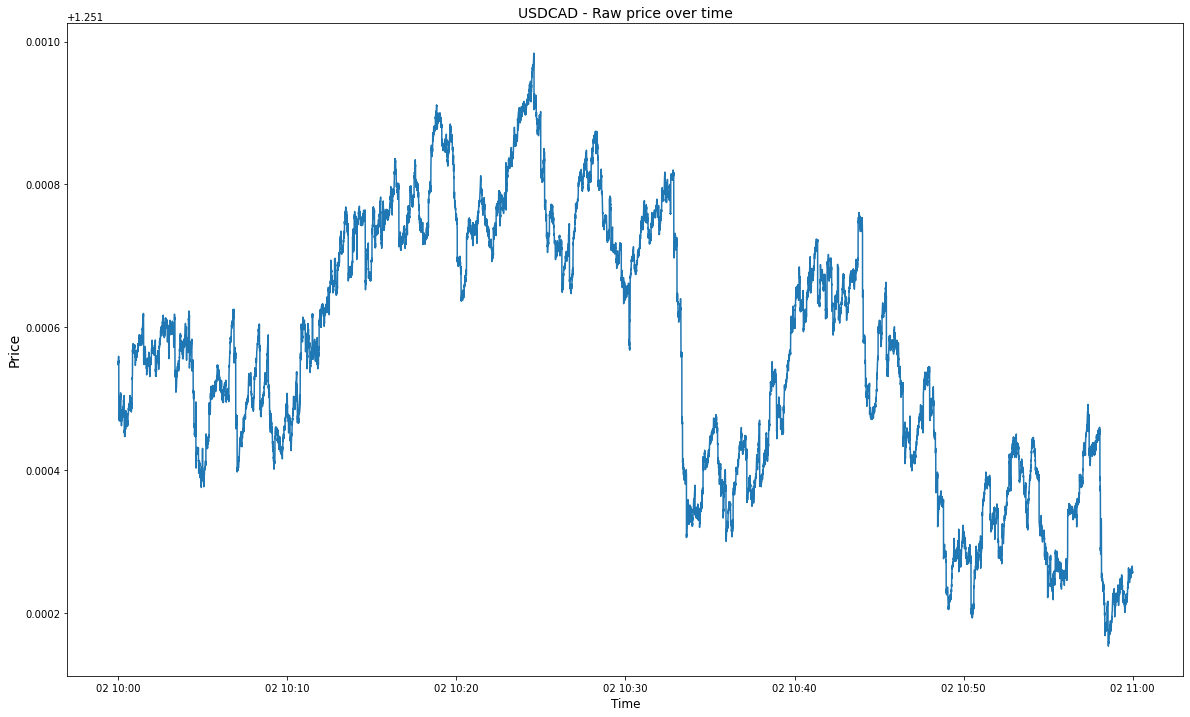

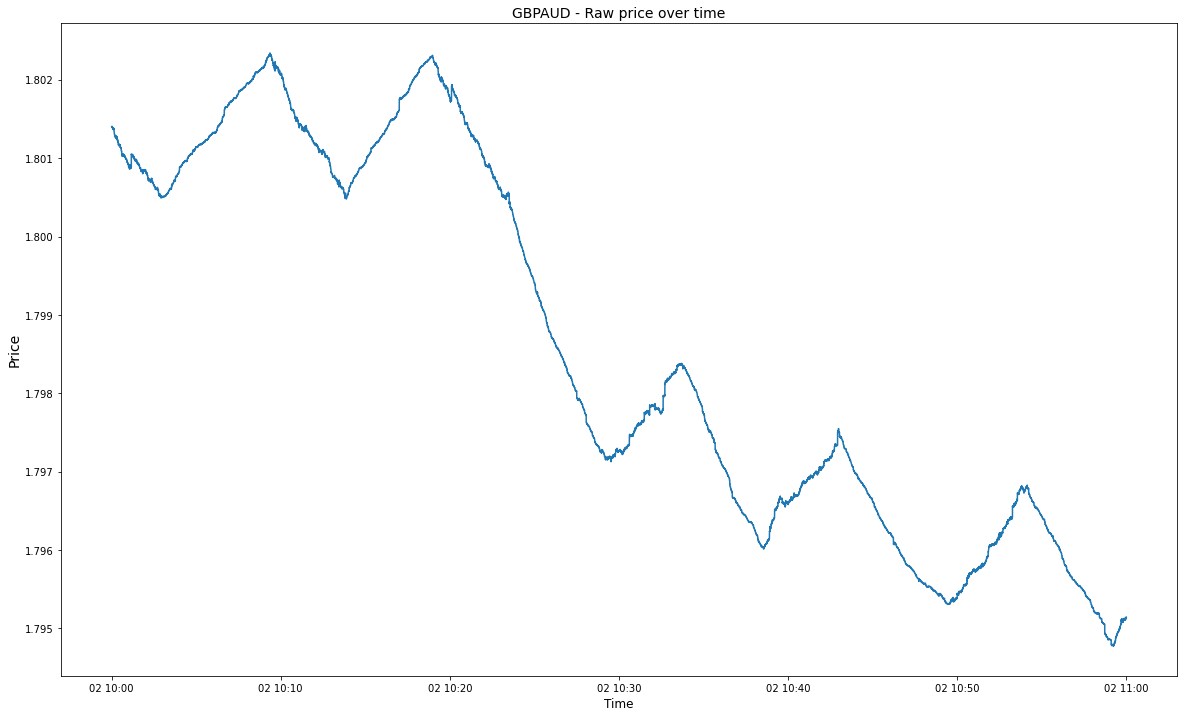

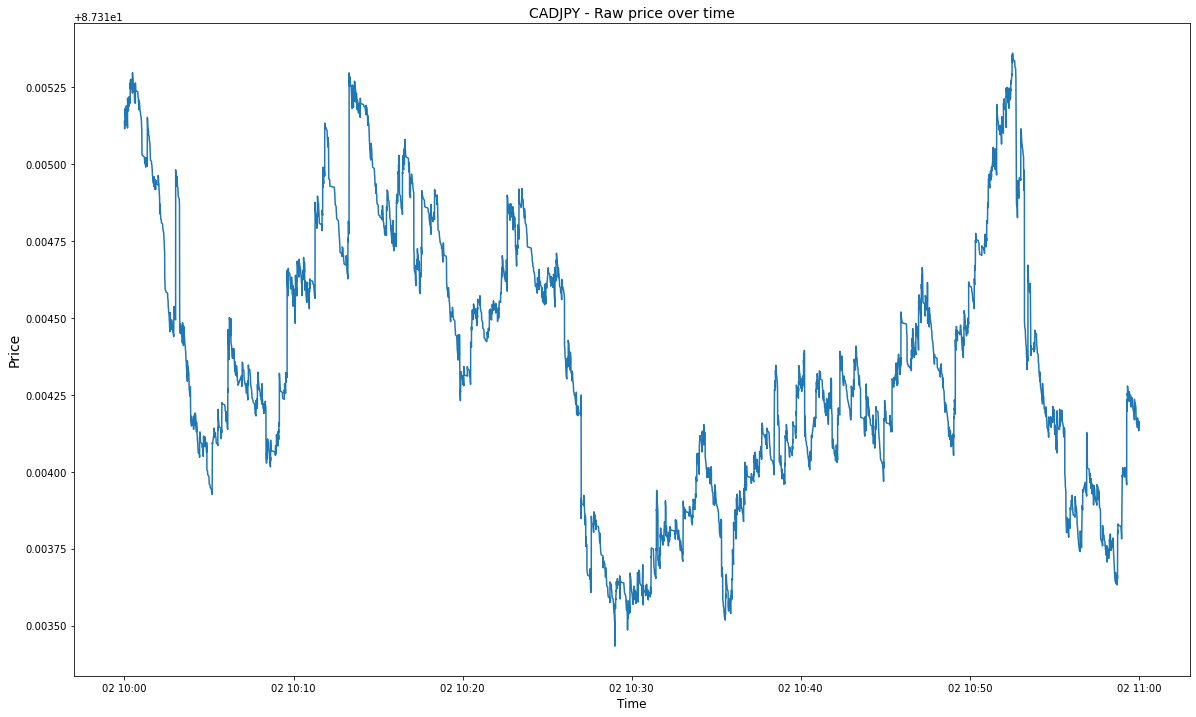

In [8]:
def plot_raw_prices_over_time(data, ccy_pairs, filter_time = 1):
    
    for ccy_pair in ccy_pairs:
        _prices = data[data['symbol']==ccy_pair].copy()
        if filter_time:
            _prices = _prices[_prices.index < _prices.index.min()+timedelta(hours=filter_time)].copy()
        
        # Plot currency pair's raw price over time
        fig, ax = plt.subplots(figsize=(20, 12))
        plt.plot(_prices.index, _prices.value)
        plt.title(f'''{ccy_pair} - Raw price over time''', fontsize=14)
        plt.xlabel("Time", fontsize=12)
        plt.ylabel("Price", fontsize=14)
    
    fig.show()
    
    
plot_raw_prices_over_time(prices, CCY_PAIRS)

Notice that the currency pairs were designed to each follow their own random walk. Additionally, the GBPAUD currency pair's data was synthesized such that when prices are increasing, this direction of price movement is maintained for a period, before switching to consistent decreasing prices for a period - this ensured a greater range of RSI values for this currency pair.

### Histogram of time difference between consecutive ticks for each currency pair

Time difference indicates how much time there is between consecutive ticks. The average for each currency pair is approximately 130 milliseconds (except CADJPY - see below for explanation).

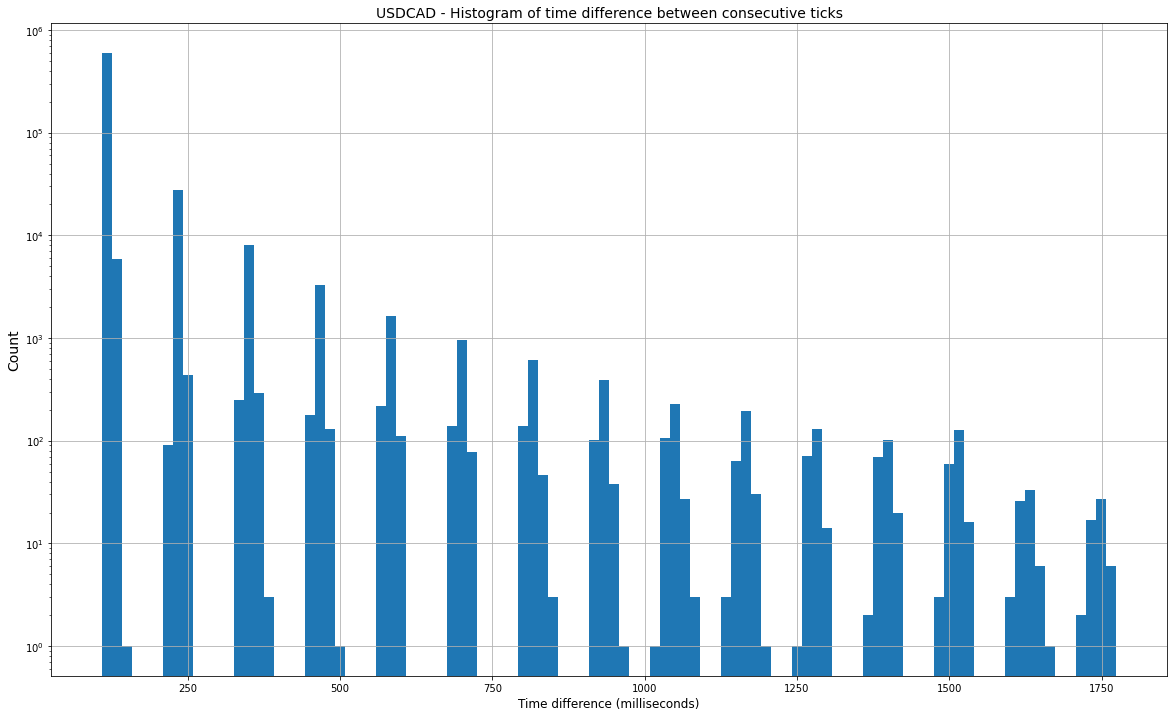

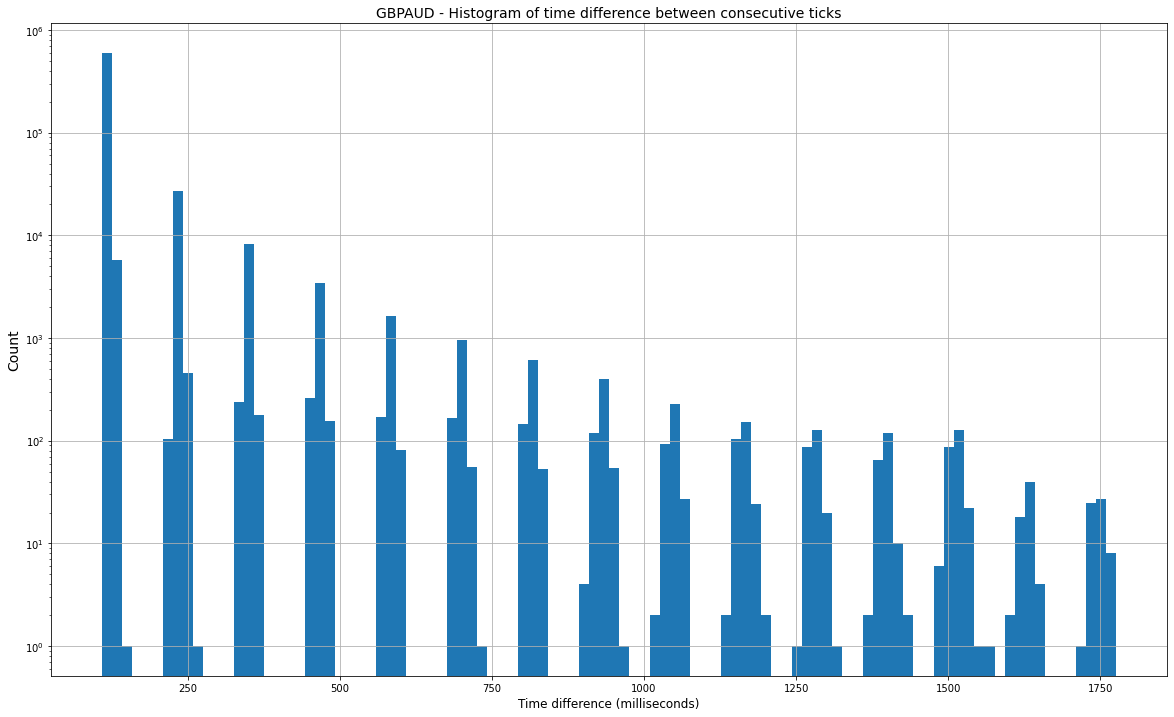

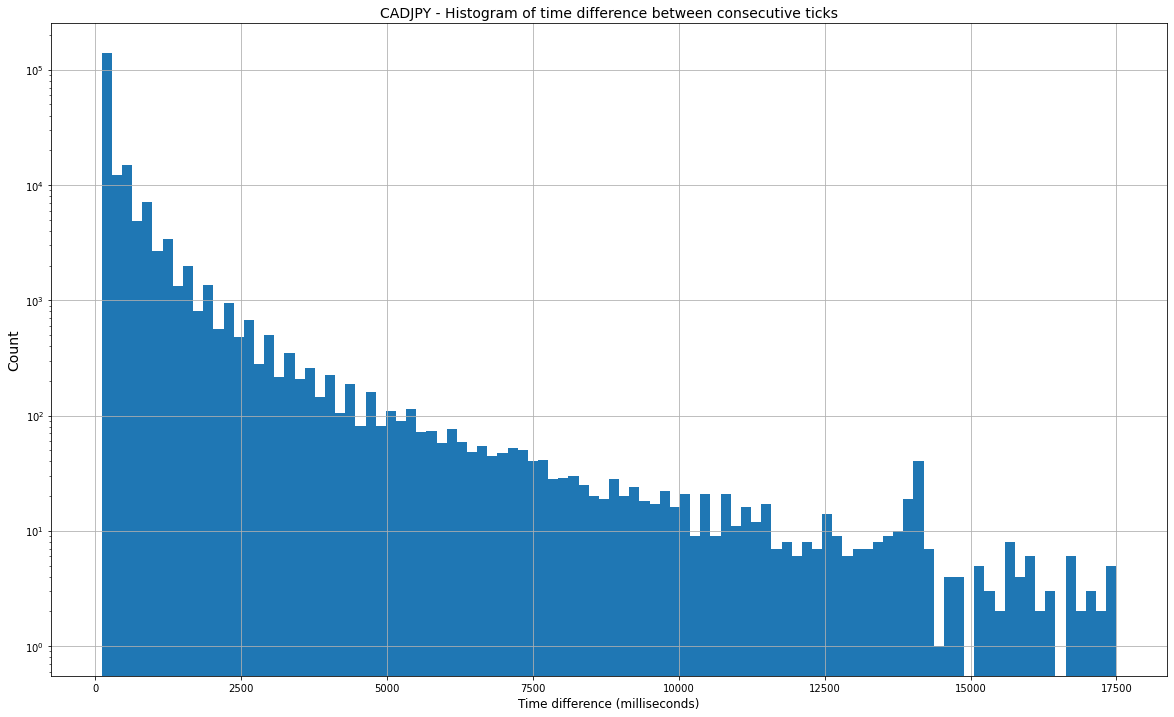

In [9]:
def plot_histograms_of_tick_time_difference(data, ccy_pairs):
    
    for ccy_pair in ccy_pairs:
        # Compute time difference in milliseconds for each currency pair
        _prices = data[data['symbol']==ccy_pair].copy()
        _prices['time_diff'] = _prices.index.to_series().diff(1).dt.total_seconds()*1000

        # Plot time difference as a histogram with a log scale y-axis
        fig, ax = plt.subplots(figsize=(20, 12))
        _prices.hist('time_diff', bins=100, ax=ax)
        ax.set_yscale('log')
        plt.title(f'''{ccy_pair} - Histogram of time difference between consecutive ticks''', fontsize=14)
        plt.xlabel("Time difference (milliseconds)", fontsize=12)
        plt.ylabel("Count", fontsize=14)
    
    plt.show()


plot_histograms_of_tick_time_difference(prices, CCY_PAIRS)

As mentioned before, note that CADJPY has greater time differences due to the data synthesizer generating CADJPY ticks at a significantly lower frequency.

## Explore metrics data

The following explores the metrics data (outputted by the TimeSeriesMetricsLibrary) for data understanding.

In [10]:
metrics.head()

,symbol,endTimestamp,MIN,MAX,FIRST,LAST,FIRST_TIMESTAMP,LAST_TIMESTAMP,DATA_POINT_COUNT,SUM,...,EXPONENTIAL_MOVING_AVERAGE,LOG_RTN,RELATIVE_STRENGTH,RELATIVE_STRENGTH_INDICATOR,BB_UPPER_BAND_EMA,BB_UPPER_BAND_SMA,BB_MIDDLE_BAND_EMA,BB_MIDDLE_BAND_SMA,BB_BOTTOM_BAND_EMA,BB_BOTTOM_BAND_SMA
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-05-02 10:00:00.999,GBPNZD,1619913601,1.958898,1.958904,1.958898,1.958904,1619913600744,1619913600977,3,5.876704,...,1.958897,4.535990e-06,0.628188,38.582045,1.959440,1.959784,1.958897,1.959241,1.958353,1.958698
2021-05-02 10:00:00.999,EURGBP,1619913601,0.848687,0.848692,0.848688,0.848689,1619913600047,1619913600860,8,6.789515,...,0.848690,-3.750001e-07,0.836461,45.547440,0.848831,0.848935,0.848690,0.848795,0.848550,0.848655
2021-05-02 10:00:00.999,EURJPY,1619913601,129.379966,129.380051,129.380030,129.379987,1619913600047,1619913600977,7,905.660061,...,129.380091,-4.960001e-07,0.796420,44.333738,129.382460,129.383049,129.380091,129.380680,129.377722,129.378311
2021-05-02 10:00:00.999,EURCAD,1619913601,1.478030,1.478043,1.478032,1.478041,1619913600047,1619913600977,9,13.302333,...,1.478035,5.133987e-06,1.192491,54.389780,1.478154,1.478110,1.478035,1.477991,1.477917,1.477873
2021-05-02 10:00:00.999,CADJPY,1619913601,87.315115,87.315140,87.315140,87.315115,1619913600047,1619913600860,7,611.205893,...,87.315126,-3.290001e-07,1.252331,55.601550,87.315587,87.315058,87.315126,87.314597,87.314665,87.314136


Below, the metrics data columns and data types are listed.

In [11]:
metrics.dtypes

symbol                          object
endTimestamp                    object
MIN                            float64
MAX                            float64
FIRST                          float64
LAST                           float64
FIRST_TIMESTAMP                  int64
LAST_TIMESTAMP                   int64
DATA_POINT_COUNT                 int64
SUM                            float64
SUM_MOVEMENT_COUNT               int64
SUM_UP_MOVEMENT                float64
SUM_DOWN_MOVEMENT              float64
STANDARD_DEVIATION             float64
SIMPLE_MOVING_AVERAGE          float64
ABS_MOVING_AVERAGE_GAIN        float64
ABS_MOVING_AVERAGE_LOSS        float64
EXPONENTIAL_MOVING_AVERAGE     float64
LOG_RTN                        float64
RELATIVE_STRENGTH              float64
RELATIVE_STRENGTH_INDICATOR    float64
BB_UPPER_BAND_EMA              float64
BB_UPPER_BAND_SMA              float64
BB_MIDDLE_BAND_EMA             float64
BB_MIDDLE_BAND_SMA             float64
BB_BOTTOM_BAND_EMA       

In [12]:
print('Total rows in the metrics dataframe is:', metrics.shape[0])
print('The min time in the raw prices dataframe is:', metrics.index.min())
print('The max time in the raw prices dataframe is:', metrics.index.max())

Total rows in the metrics dataframe is: 1468800
The min time in the raw prices dataframe is: 2021-05-02 10:00:00.999000
The max time in the raw prices dataframe is: 2021-05-03 09:59:59.999000


### Prices per currency pair in metrics data

In [13]:
metrics['symbol'].value_counts()

AUDJPY    86400
GBPNZD    86400
EURJPY    86400
EURCAD    86400
GBPJPY    86400
EURAUD    86400
EURUSD    86400
EURGBP    86400
USDCAD    86400
CADJPY    86400
USDCHF    86400
NZDUSD    86400
GBPAUD    86400
GBPUSD    86400
AUDUSD    86400
USDJPY    86400
GBPCHF    86400
Name: symbol, dtype: int64

Note that all currencies have an equal number of metrics data points - this is due to the gap filling and sliding window processing done by the TimeSeriesPipeline library.

### Plots of metrics over time

In [14]:
def plot_metric_over_time(data, metric_names, ccy_pairs, filter_time=1):
    
    for ccy_pair in ccy_pairs:
        _metrics = data[data['symbol']==ccy_pair]
        if filter_time:
            _metrics = _metrics[_metrics.index < _metrics.index.min()+timedelta(hours=filter_time)].copy()
        fig, ax = plt.subplots(figsize=(20, 12))
        
        # Plot one metric
        if isinstance(metric_names, str):
            metric_name_label = metric_names.lower().replace('_', ' ')
            plt.plot(_metrics.index, _metrics[metric_names], label=metric_name_label)
            plt.title(f'''{ccy_pair} - {metric_name_label} over time''', fontsize=14)
            plt.xlabel("Time", fontsize=12)
            plt.ylabel(metric_name_label, fontsize=14)
        
        # Plot multiple metrics on the same plot
        elif isinstance(metric_names, list):
            for _m in metric_names:
                plt.plot(_metrics.index, _metrics[_m], label=_m.lower().replace('_', ' '))
                
            plt.title(f'''{ccy_pair} - Bollinger bands over time''', fontsize=18)
            plt.xlabel("Time", fontsize=12)
            plt.ylabel("Price", fontsize=14)
            plt.legend(loc='best')

    fig.show()
    

def compare_metric_to_raw_prices(prices_df, metrics_df, metric_name, ccy_pairs, filter_time=1):
    
    for ccy_pair in ccy_pairs:
        _metrics = metrics_df[metrics_df['symbol']==ccy_pair].copy()
        if filter_time:
            _metrics = _metrics[_metrics.index < _metrics.index.min()+timedelta(hours=filter_time)].copy()
        _prices = prices_df[prices_df['symbol']==ccy_pair].copy()
        if filter_time:
            _prices = _prices[_prices.index < _prices.index.min()+timedelta(hours=filter_time)].copy()
        
        # Plot metric vs raw prices
        fig, ax = plt.subplots(figsize=(20, 12))
        metric_name_label = metric_name.lower().replace('_', ' ')
        plt.plot(_metrics.index, _metrics[metric_name], linewidth=4, label=metric_name_label)
        plt.plot(_prices.index, _prices['value'], label=f'{ccy_pair} raw price')
        plt.title(f'''{ccy_pair} - {metric_name_label} vs raw prices''', fontsize=18)
        plt.xlabel("Time", fontsize=12)
        plt.ylabel("Price", fontsize=14)
        plt.legend(loc='best')
        
    fig.show()

#### Simple moving average

As expected, the simple moving average curve follows the raw price random walk closely.

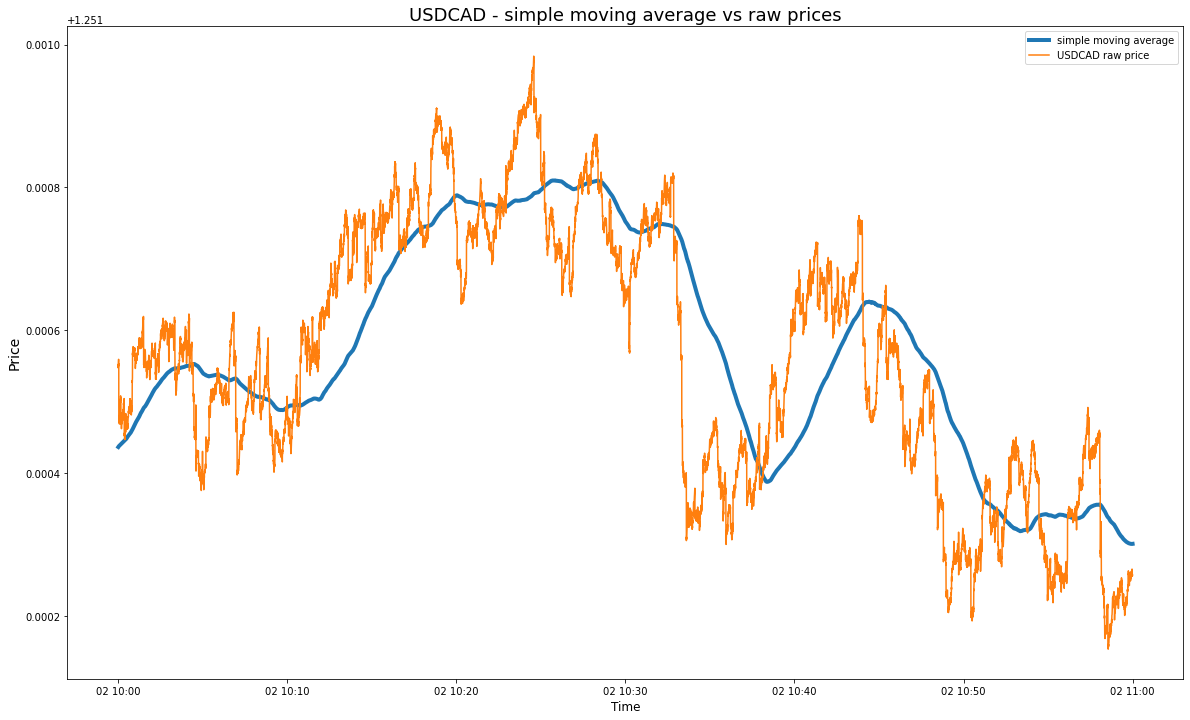

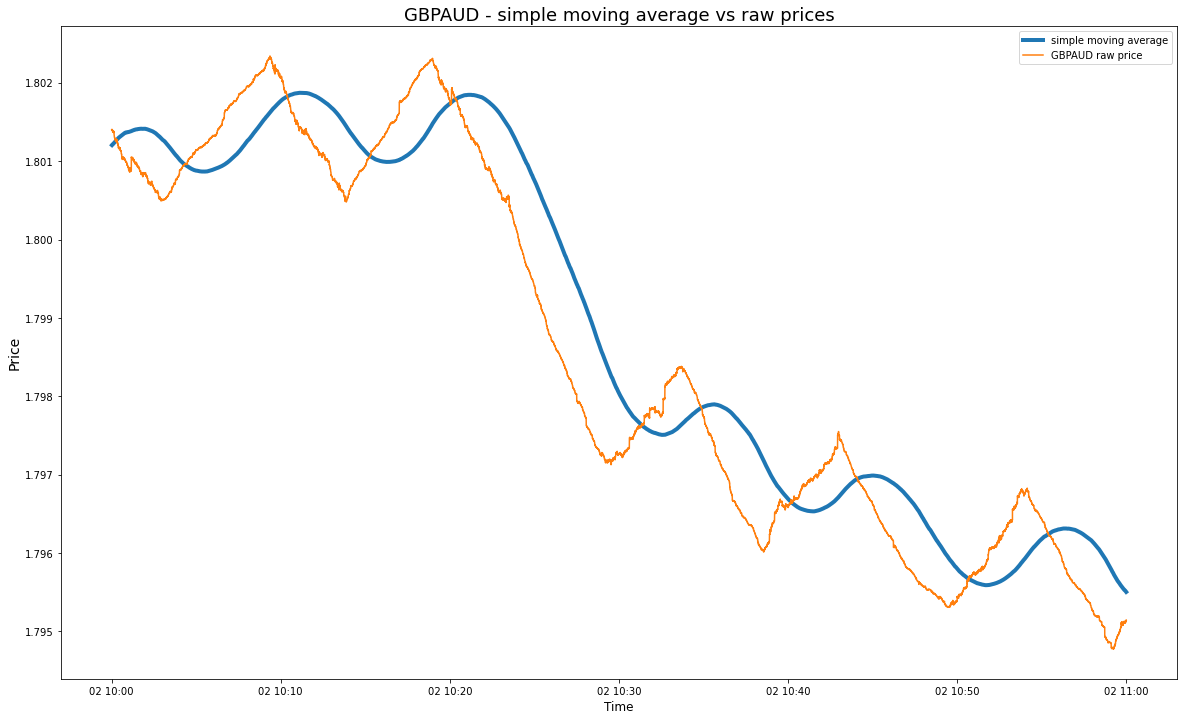

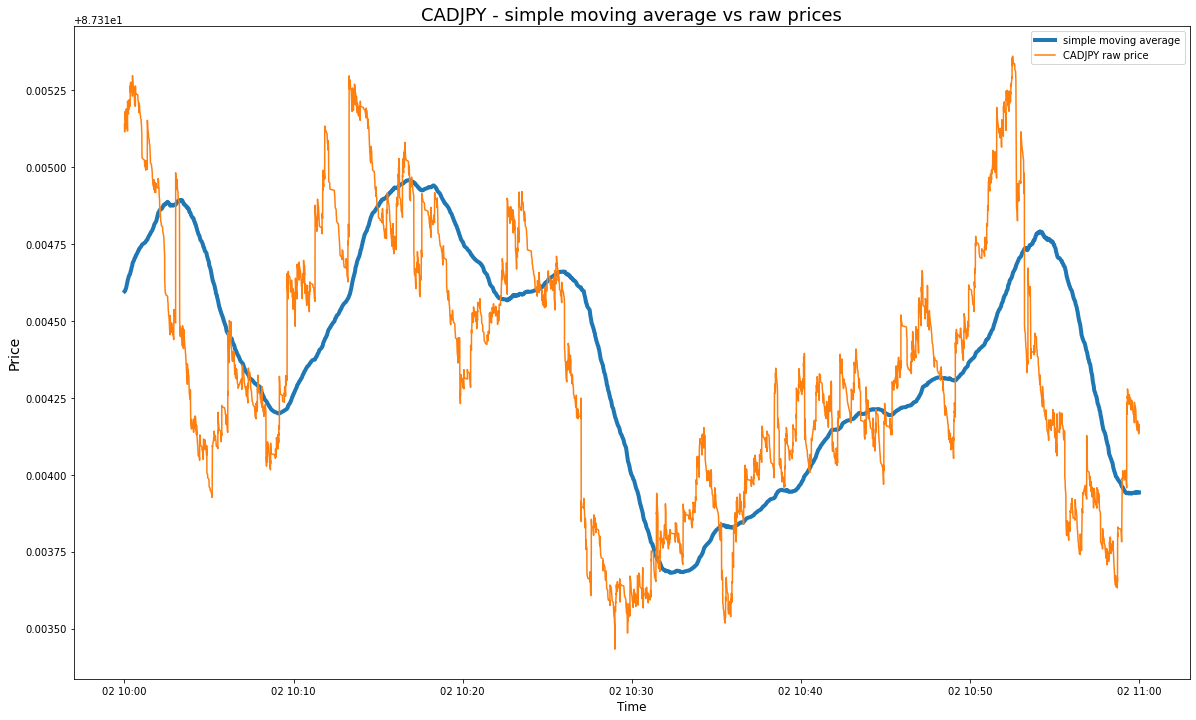

In [15]:
compare_metric_to_raw_prices(prices, metrics, 'SIMPLE_MOVING_AVERAGE', CCY_PAIRS)

#### Exponential moving average

Note that the plots are overlapping for the exponential moving average metric as this metric has very similar values to the raw prices. This is because the windows over which the metrics are calculated across is only 5 minutes.

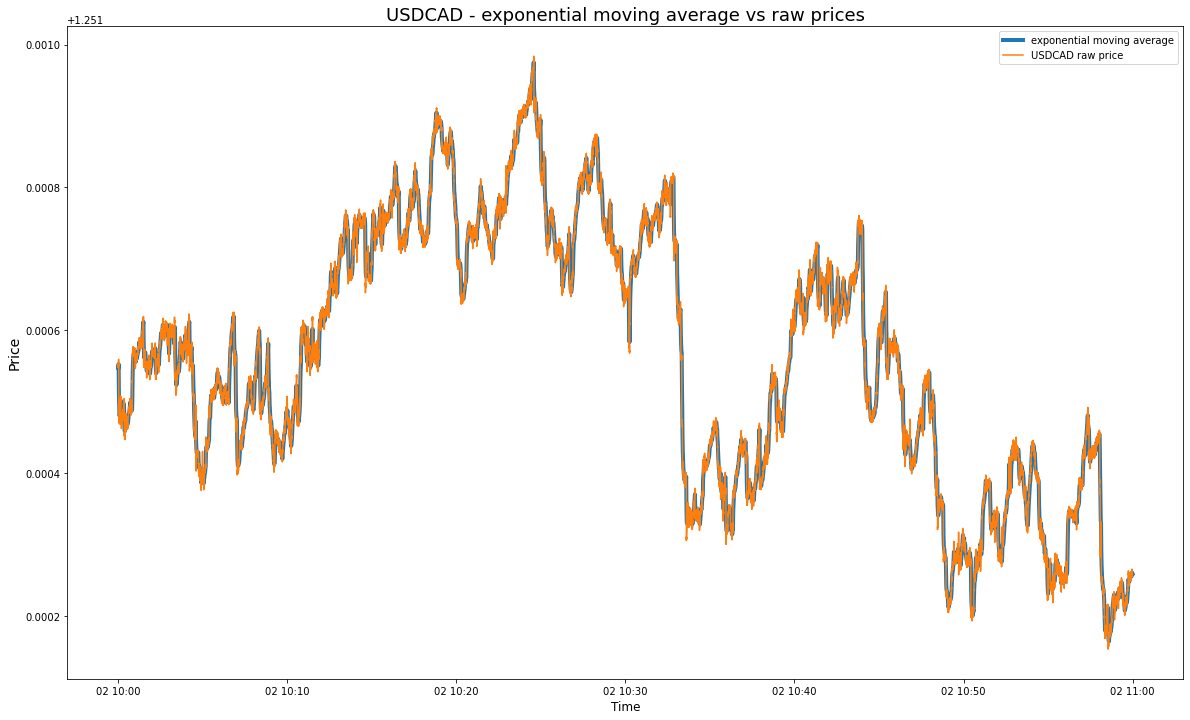

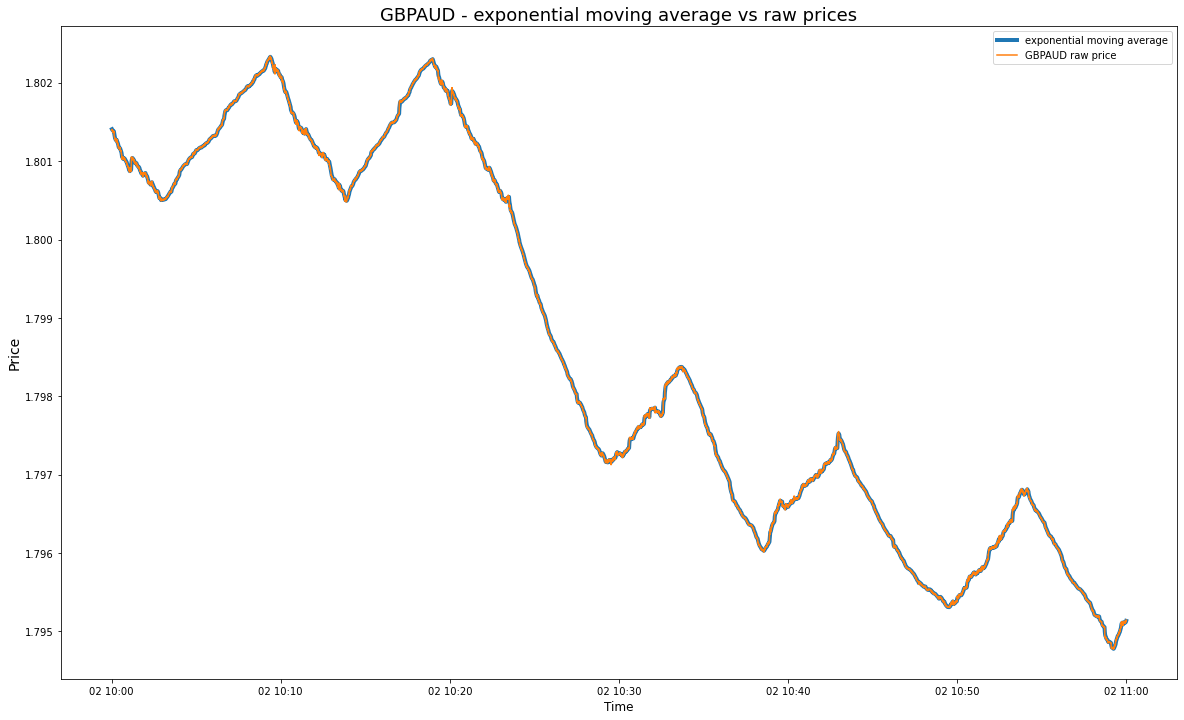

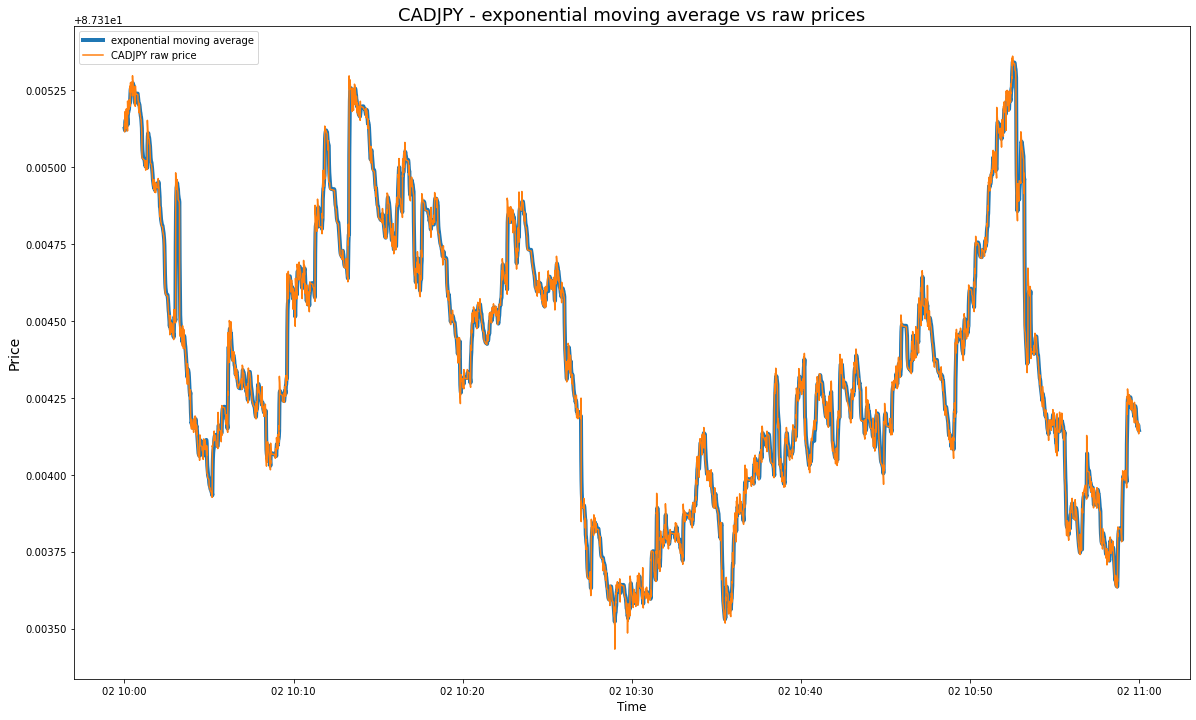

In [16]:
compare_metric_to_raw_prices(prices, metrics, 'EXPONENTIAL_MOVING_AVERAGE', CCY_PAIRS)

#### Relative strength indicator

Notice that the range of RSI values for GBPAUD is much greater than the other currency pairs. As mentioned previously, this is by design as the GBPAUD currency pair is to be used in the model inferring unreliable RSI.

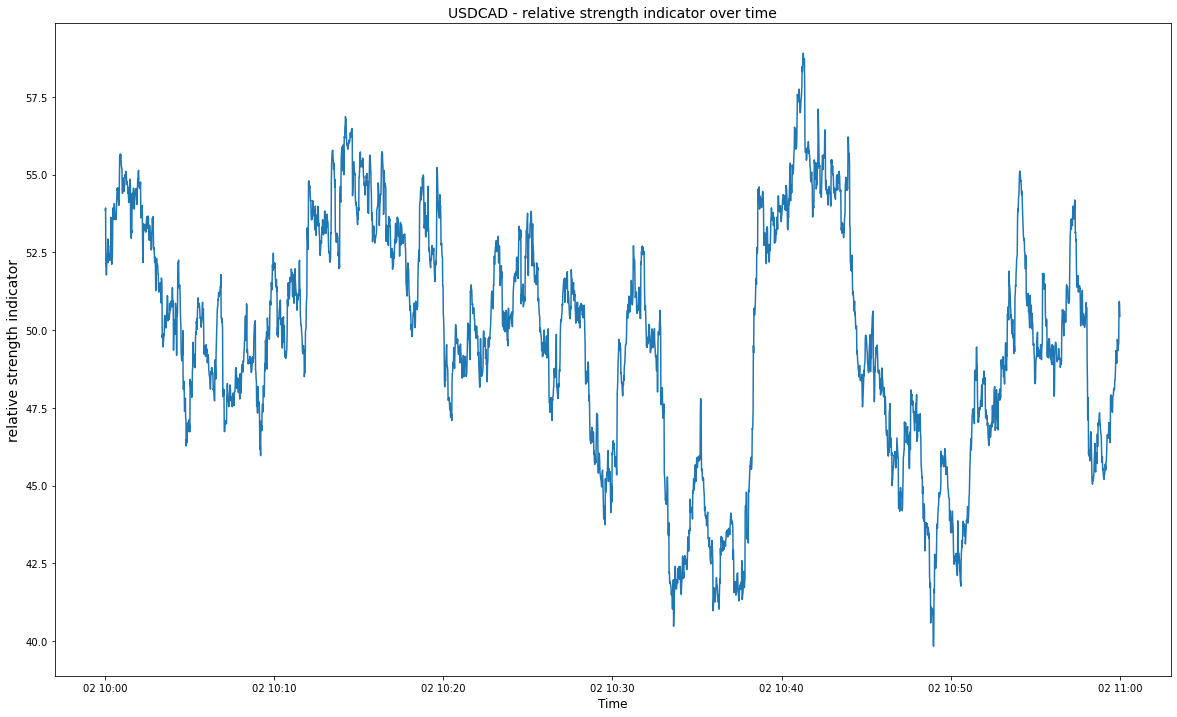

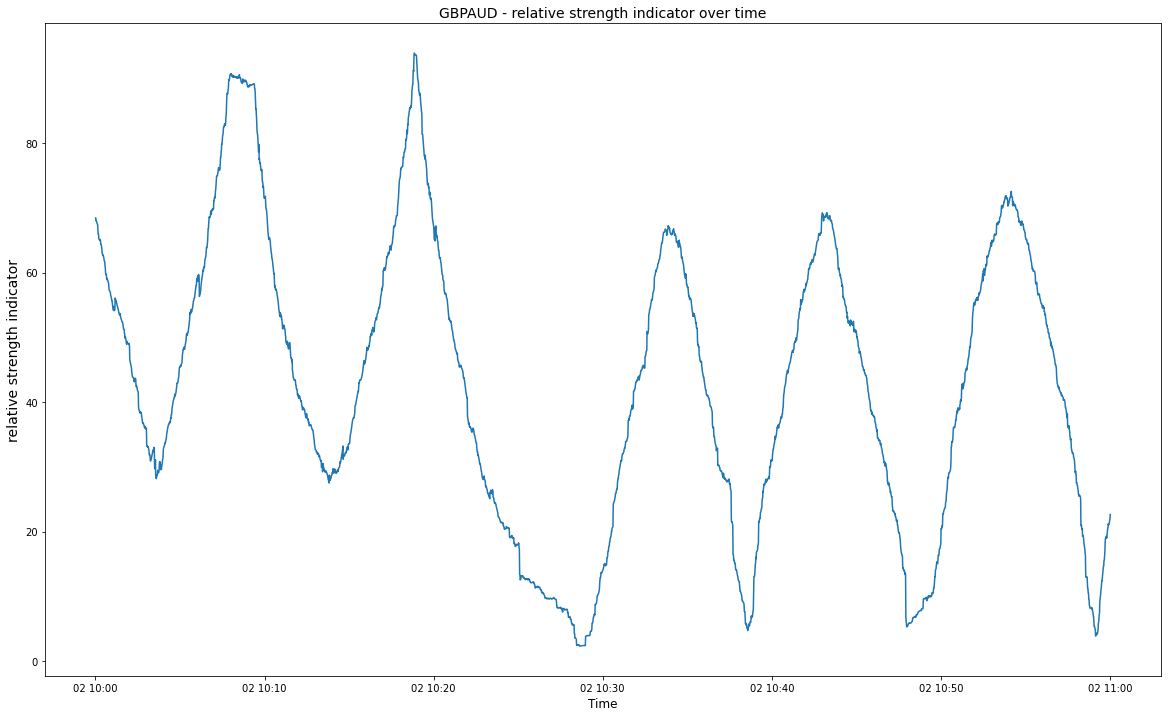

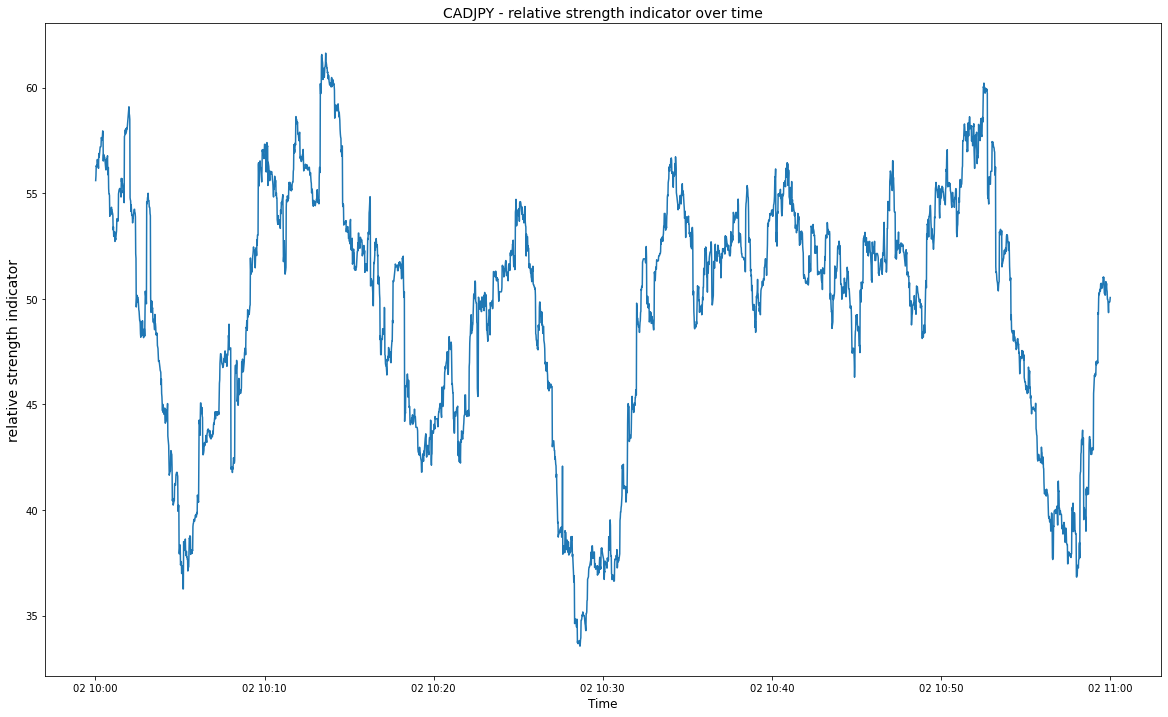

In [17]:
plot_metric_over_time(metrics, 'RELATIVE_STRENGTH_INDICATOR', CCY_PAIRS)

#### Log returns

Log returns is a measure for the price change of an asset.

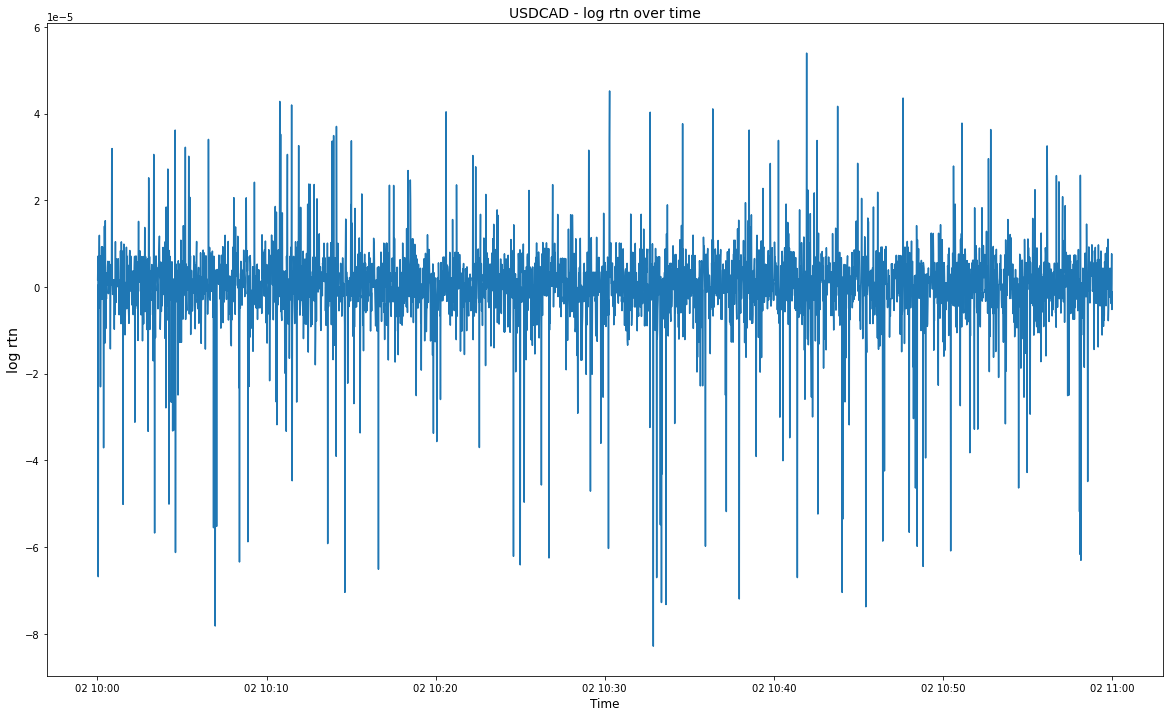

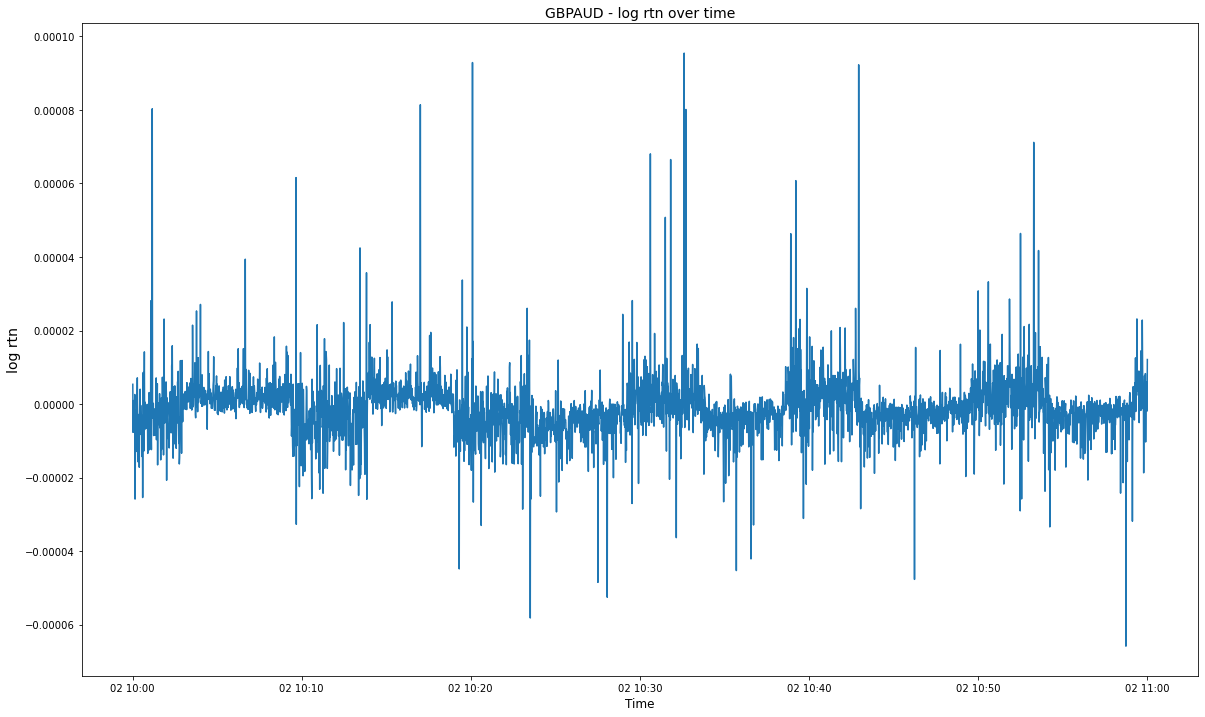

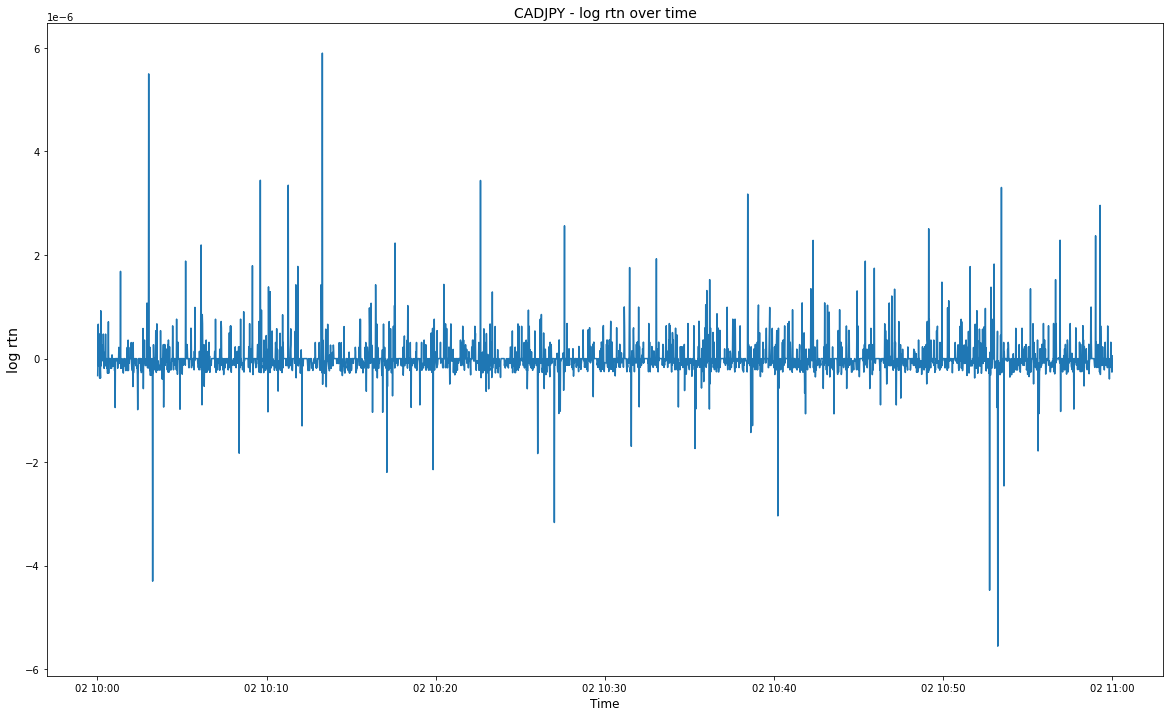

In [18]:
plot_metric_over_time(metrics, 'LOG_RTN', CCY_PAIRS)

#### Bollinger bands (simple moving average)

Bollinger bands are confidence intervals typically plus/minus 2 standard deviations from a moving average, in this case simple moving average.

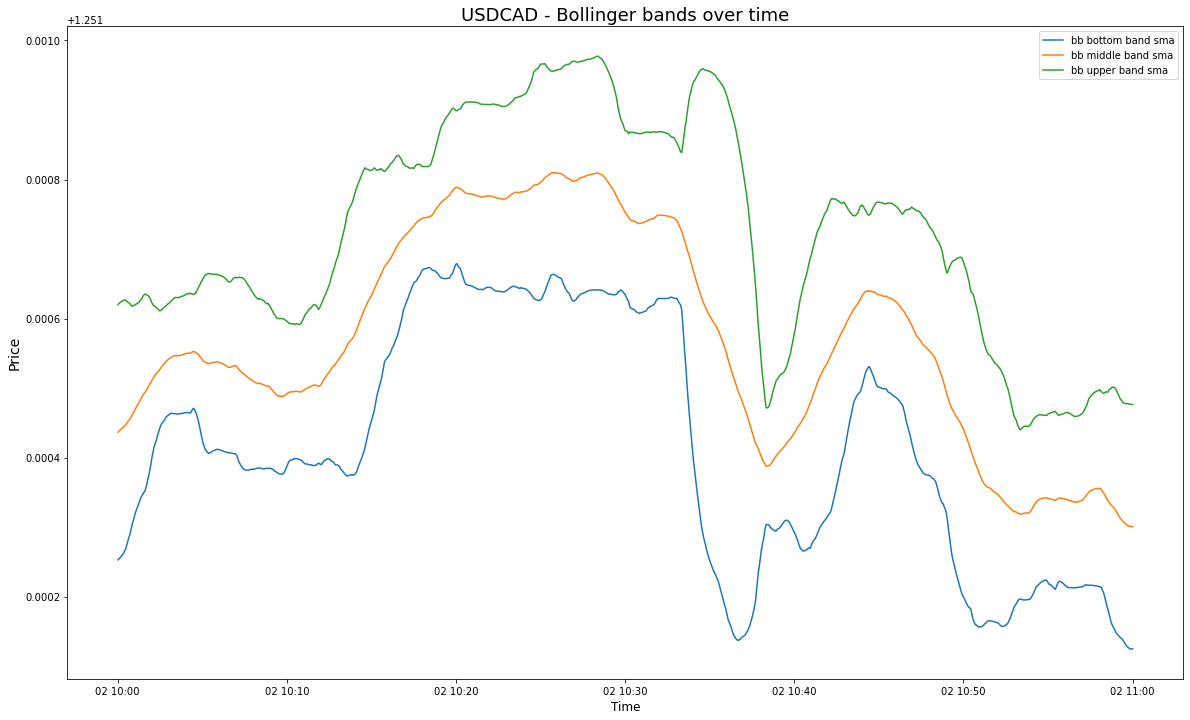

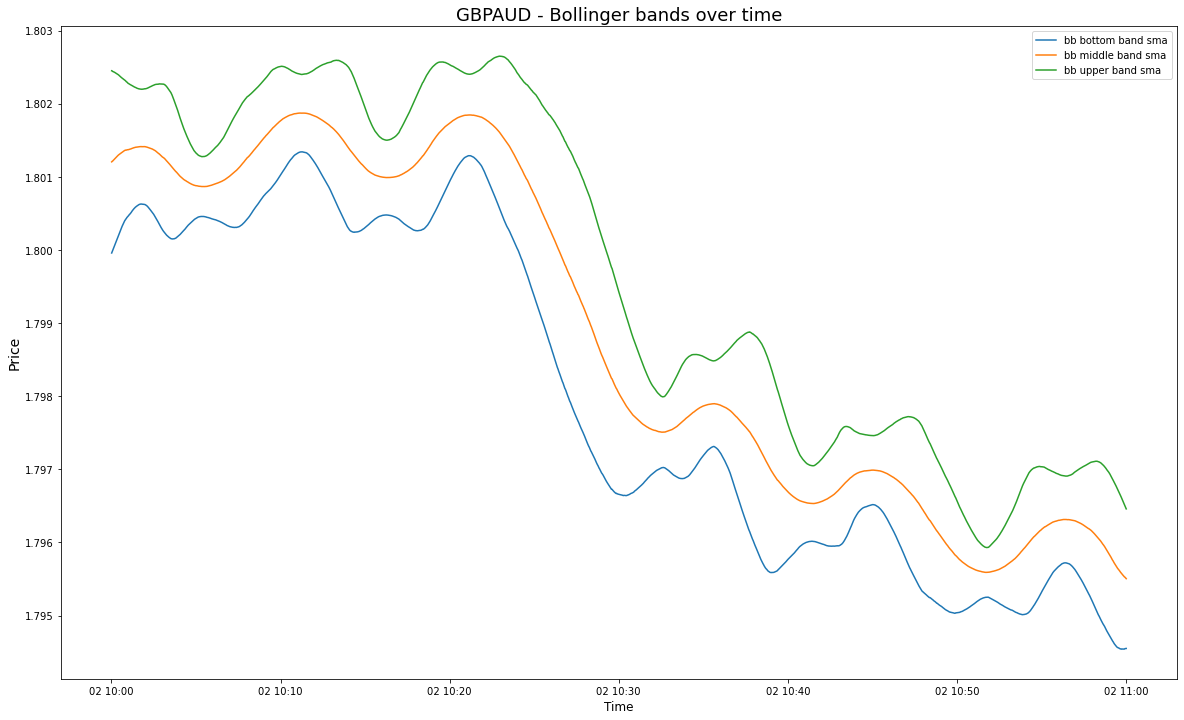

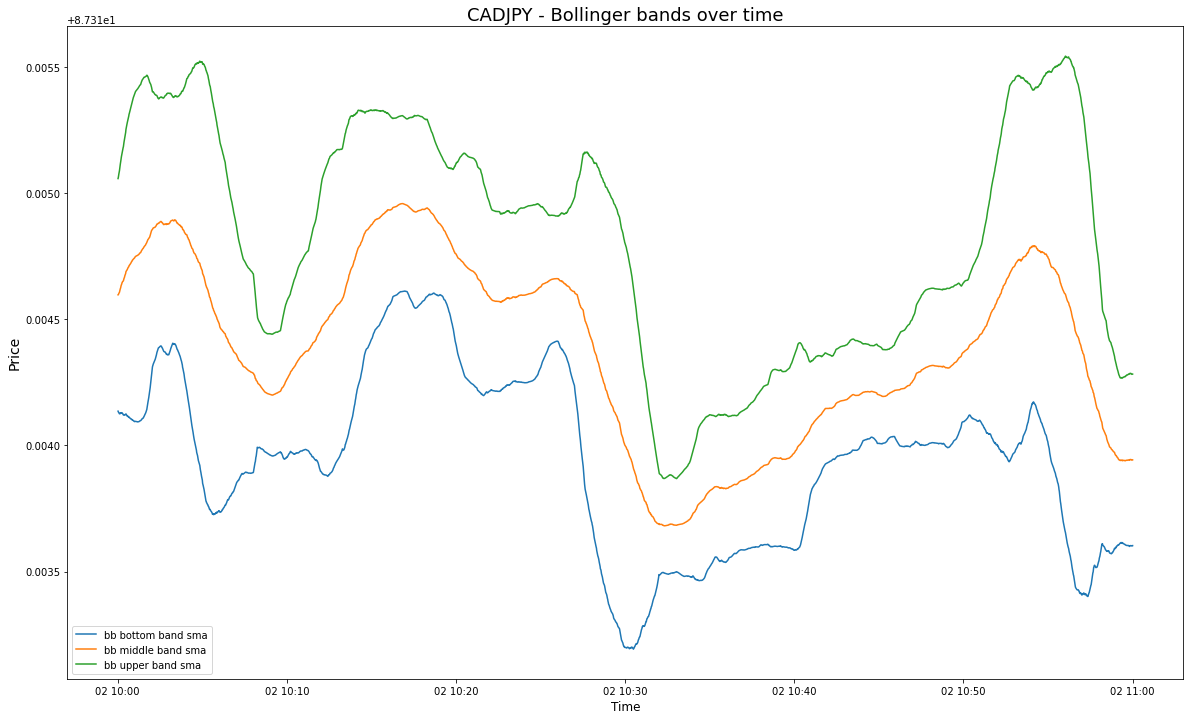

In [19]:
plot_metric_over_time(metrics, ['BB_BOTTOM_BAND_SMA', 'BB_MIDDLE_BAND_SMA', 'BB_UPPER_BAND_SMA'], CCY_PAIRS)

#### Bollinger bands (exponential moving average)

The Bollinger bands below are relative to the exponential moving average.

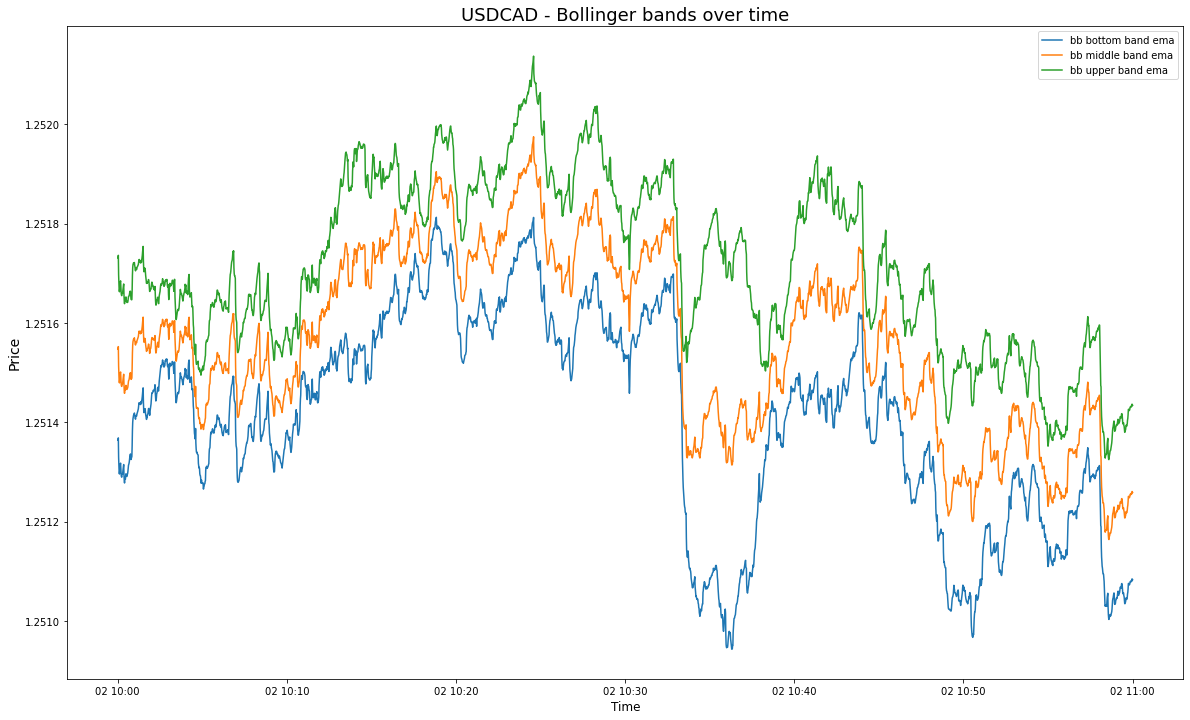

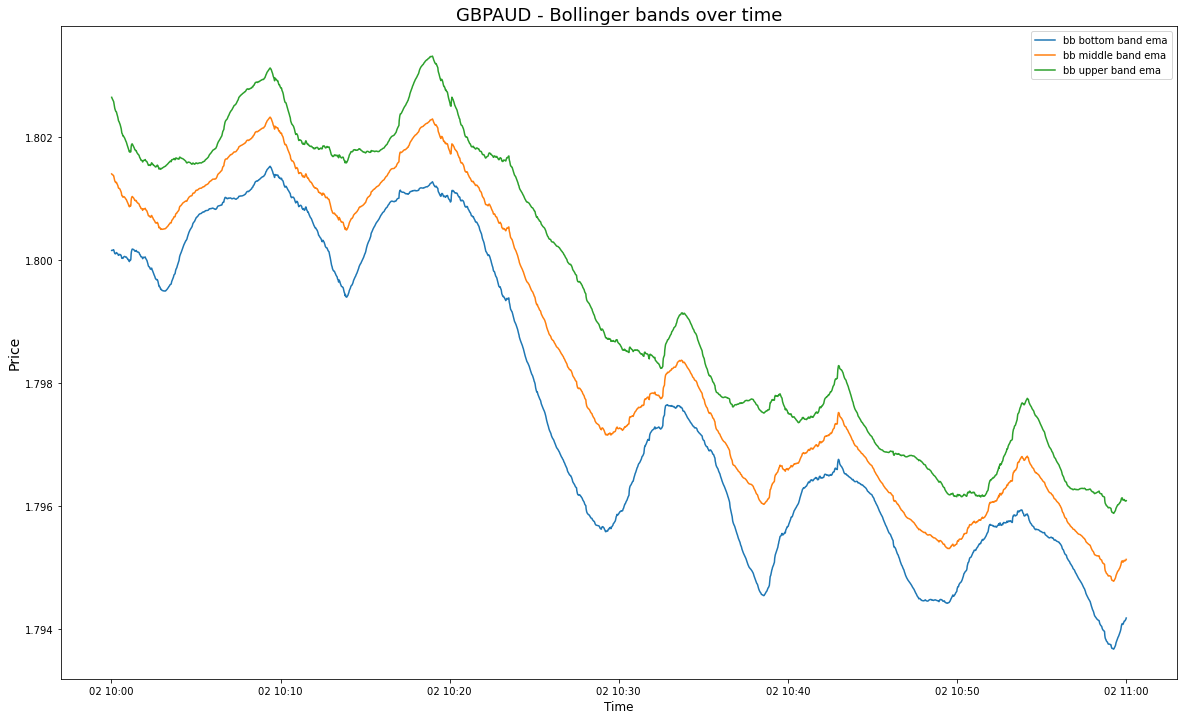

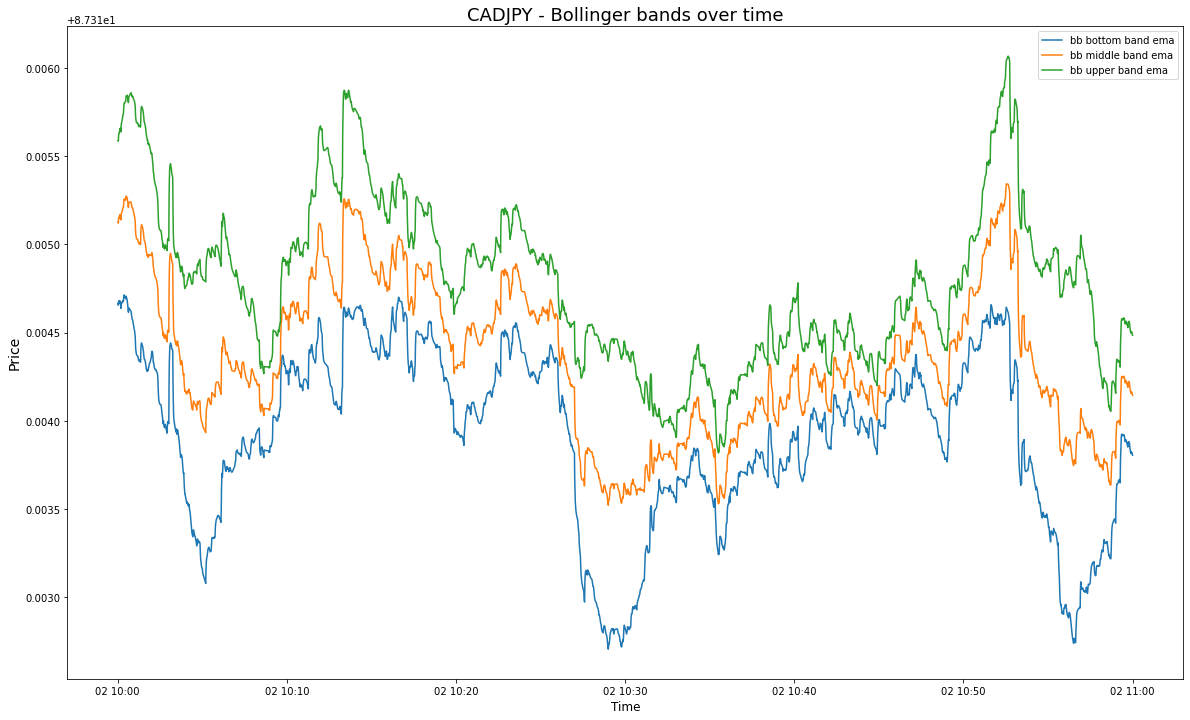

In [20]:
plot_metric_over_time(metrics, ['BB_BOTTOM_BAND_EMA', 'BB_MIDDLE_BAND_EMA', 'BB_UPPER_BAND_EMA'], CCY_PAIRS)

## Data exploration for foreign exchange use case

The use case is applied to the currency pair GBPAUD, so the analysis and plots below are for this currency pair.

In [21]:
gbpaud_metrics = metrics[metrics['symbol']=='GBPAUD'].copy()

Given this use case requires finding anomalies in metrics when RSI > 70 or RSI < 30, we create a column to reflect when this RSI condition is true vs false.

In [22]:
def create_column_indicating_when_RSI_condition_true(data, RSI_buy_bound = 30, RSI_sell_bound = 70):
    
    data['RSI_condition'] = np.where((
          (data['RELATIVE_STRENGTH_INDICATOR'] < RSI_buy_bound) 
        | (data['RELATIVE_STRENGTH_INDICATOR'] > RSI_sell_bound)), 1, 0)
    
    return data

gbpaud_metrics_rsi_cond = create_column_indicating_when_RSI_condition_true(gbpaud_metrics)

For this use case, we are interested in the 5 metrics listed below which are all outputted by the TimeSeriesMetricsLibrary.

In [23]:
METRIC_COLUMNS = ['SIMPLE_MOVING_AVERAGE',
                  'EXPONENTIAL_MOVING_AVERAGE',
                  'STANDARD_DEVIATION',
                  'RELATIVE_STRENGTH_INDICATOR',
                  'LOG_RTN']

gbpaud_metrics[METRIC_COLUMNS].head()

,SIMPLE_MOVING_AVERAGE,EXPONENTIAL_MOVING_AVERAGE,STANDARD_DEVIATION,RELATIVE_STRENGTH_INDICATOR,LOG_RTN
timestamp,,,,,
2021-05-02 10:00:00.999,1.801205,1.801407,0.000623,68.468286,5.370986e-06
2021-05-02 10:00:01.999,1.801209,1.801400,0.000620,68.061119,-7.704030e-06
2021-05-02 10:00:02.999,1.801213,1.801397,0.000617,68.077047,9.499995e-07
2021-05-02 10:00:03.999,1.801214,1.801393,0.000614,67.881505,-2.557003e-06
2021-05-02 10:00:04.999,1.801218,1.801391,0.000611,67.761061,-6.750002e-07


In [24]:
gbpaud_metrics[METRIC_COLUMNS].describe()

,SIMPLE_MOVING_AVERAGE,EXPONENTIAL_MOVING_AVERAGE,STANDARD_DEVIATION,RELATIVE_STRENGTH_INDICATOR,LOG_RTN
count,86400.000000,86400.000000,86400.000000,86400.000000,8.640000e+04
mean,1.798322,1.798321,0.000508,49.243730,2.660168e-09
std,0.002503,0.002561,0.000206,29.616215,9.047883e-06
min,1.793951,1.793636,0.000089,0.501071,-1.194521e-04
25%,1.796124,1.796087,0.000341,22.708787,-3.693007e-06
50%,1.797962,1.797929,0.000480,49.483493,-2.560000e-07
75%,1.800584,1.800575,0.000649,74.212873,3.295995e-06
max,1.803637,1.803943,0.001091,99.254879,1.710624e-04


### Plot metrics over time indicating when RSI condition is true vs false

The following plots show the metrics for GBPAUD, indicating when RSI > 70 or RSI < 30 by a green shade, and red shade when the RSI condition is not true. The plots are for 1 hour of data to make them more readable.

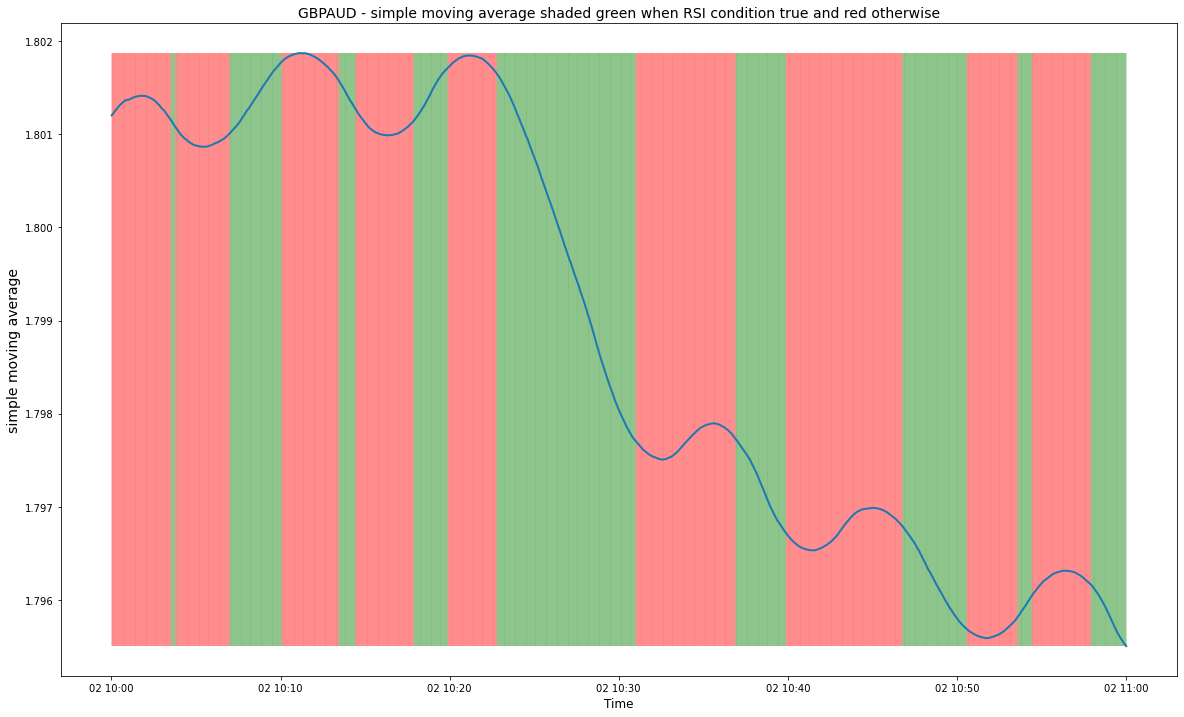

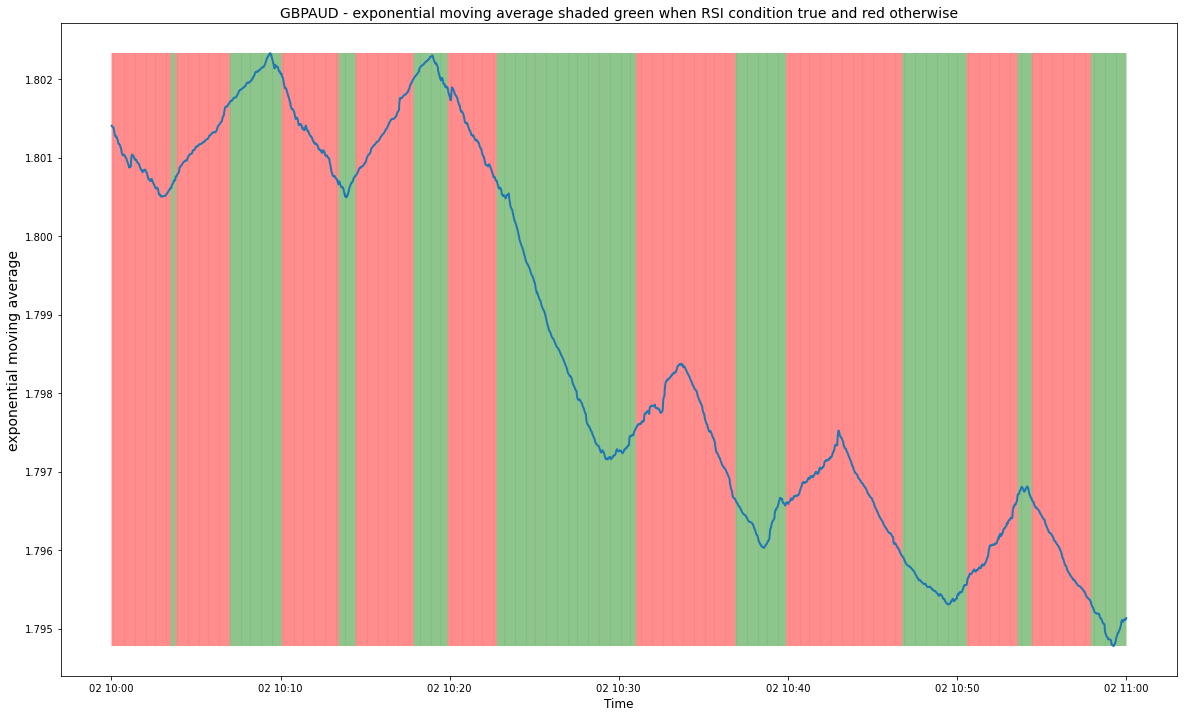

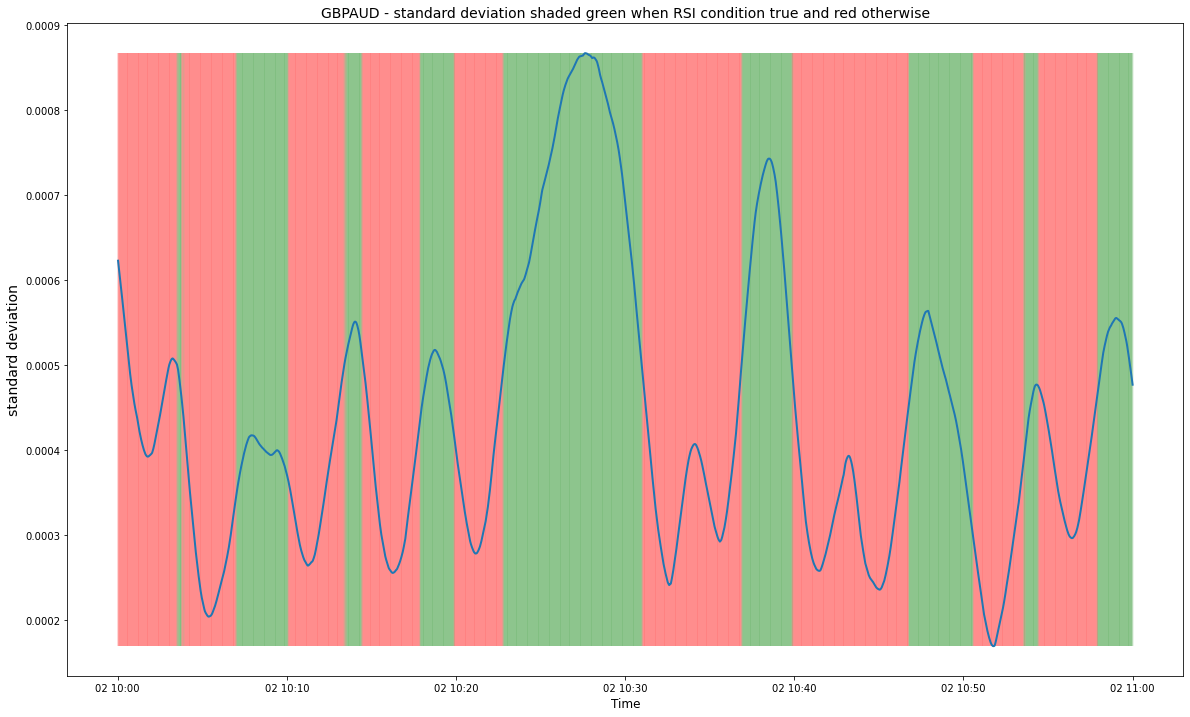

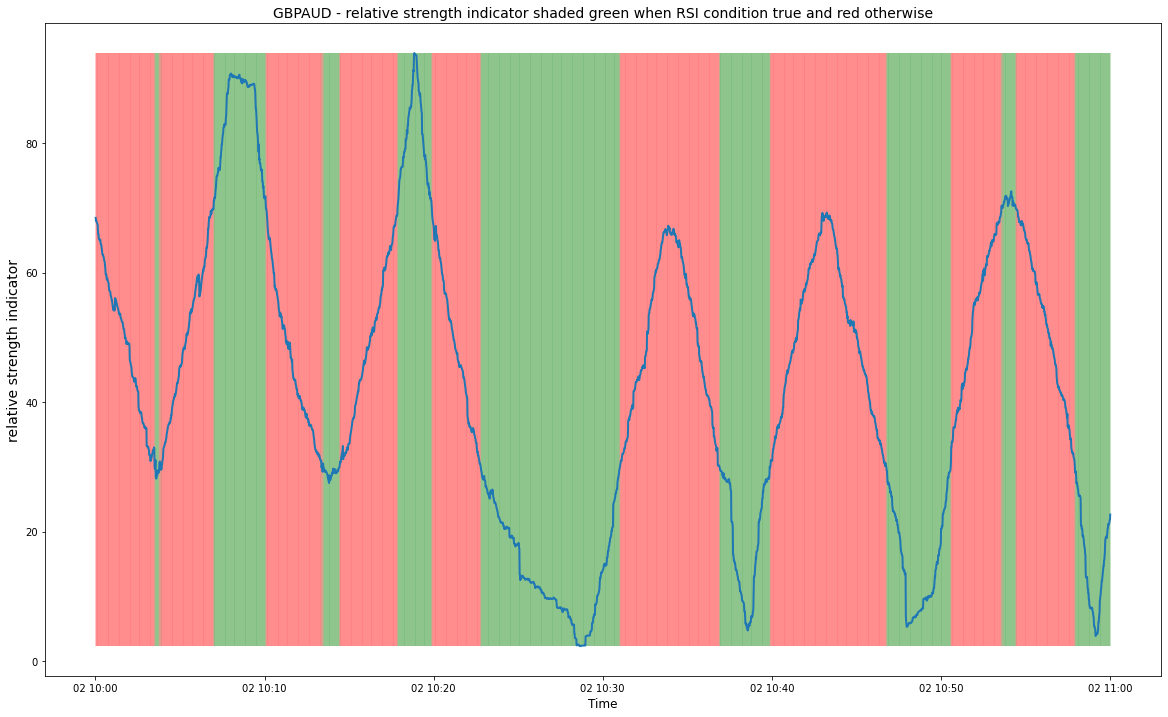

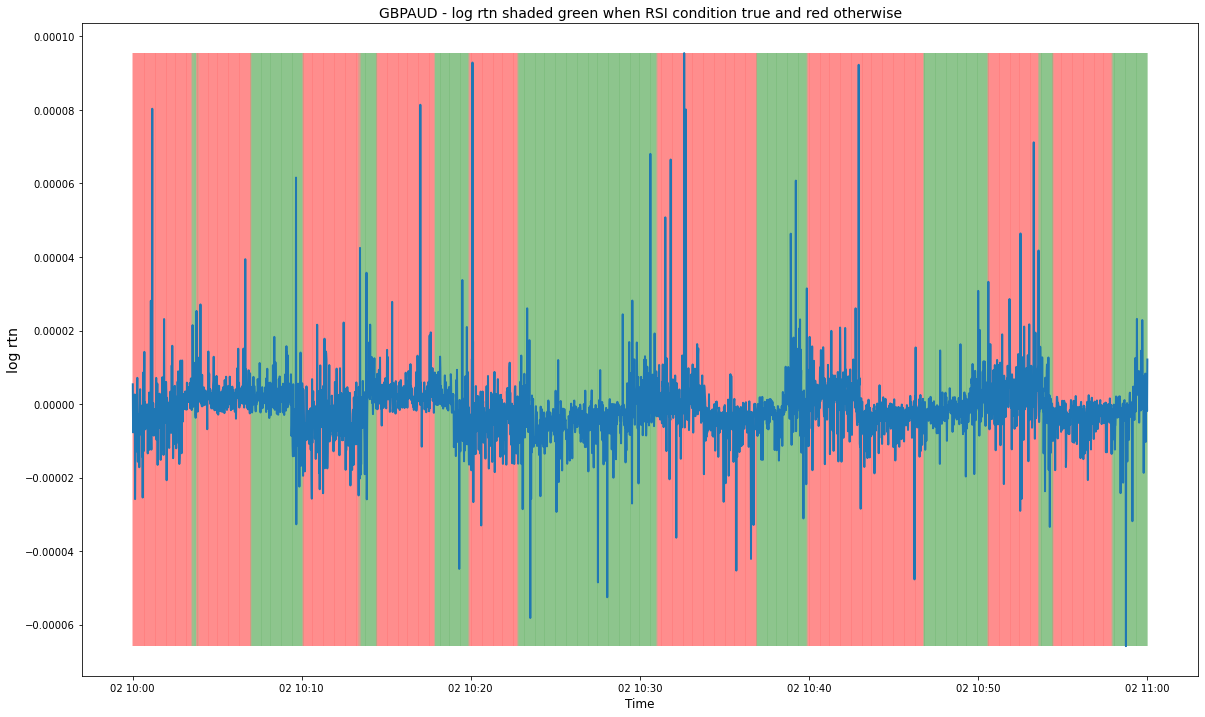

In [25]:
def plot_metric_over_time_with_rsi_condition_shaded(data, metric_name, filter_time = 1, ccy_pair = 'GBPAUD'):
    
    _metrics = data[data['symbol']==ccy_pair]
    if filter_time:
        _metrics = _metrics[_metrics.index < _metrics.index.min()+timedelta(hours=filter_time)].copy()
        
    fig, ax = plt.subplots(figsize=(20, 12))
    
    # Plot the metric over time
    plt.plot(_metrics.index, _metrics[metric_name], linewidth=2)
    
    # Plot green shading where RSI condition true (RSI > 70 or RSI < 30)
    plt.vlines(_metrics[_metrics['RSI_condition']==1].index.tolist(), _metrics[metric_name].min(), _metrics[metric_name].max(), color='green', alpha=0.1, label='RSI condition true')
    
    # Plot red shading where RSI condition false (30 < RSI < 70)
    plt.vlines(_metrics[_metrics['RSI_condition']==0].index.tolist(), _metrics[metric_name].min(), _metrics[metric_name].max(), color='red', alpha=0.1, label='RSI condition false')
    
    plt.title(f'''{ccy_pair} - {metric_name.lower().replace('_', ' ')} shaded green when RSI condition true and red otherwise''', fontsize=14)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel(metric_name.lower().replace('_', ' '), fontsize=14)
    
    fig.show()


for metric in METRIC_COLUMNS:
    plot_metric_over_time_with_rsi_condition_shaded(gbpaud_metrics_rsi_cond, metric)

### Histogram of metrics after filtering by RSI condition

Below are plots of the metrics' histograms (after filtering) to get a sense of their distributions and possible anomalies.

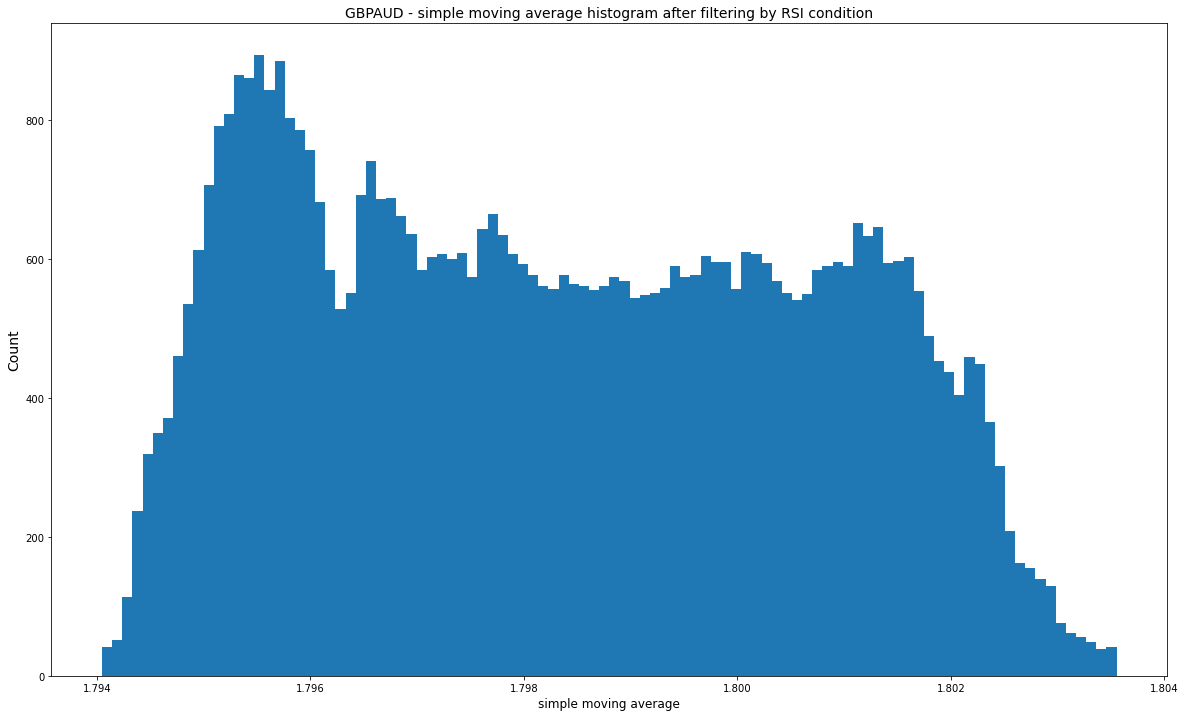

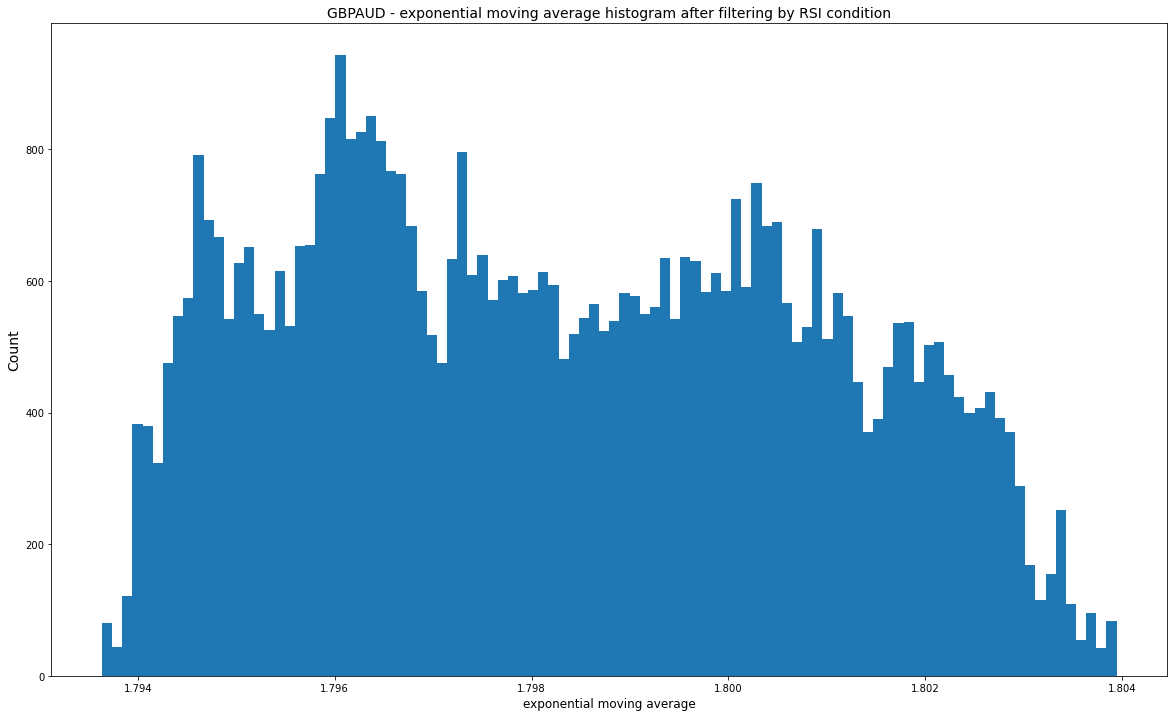

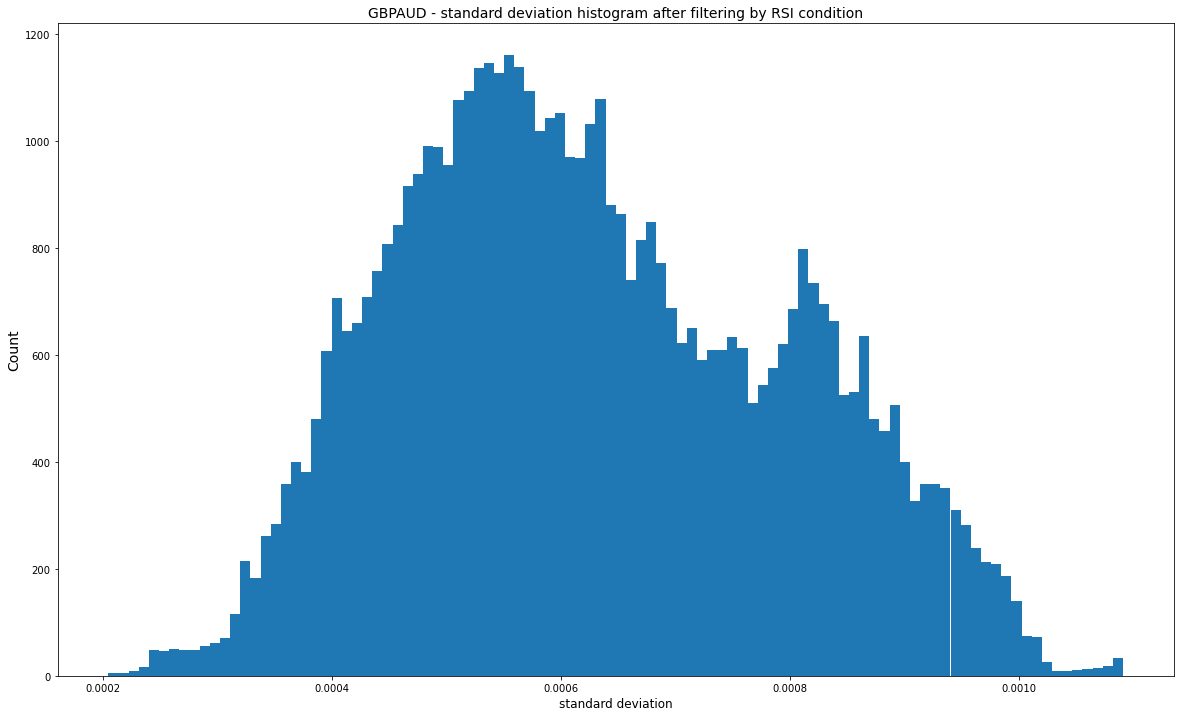

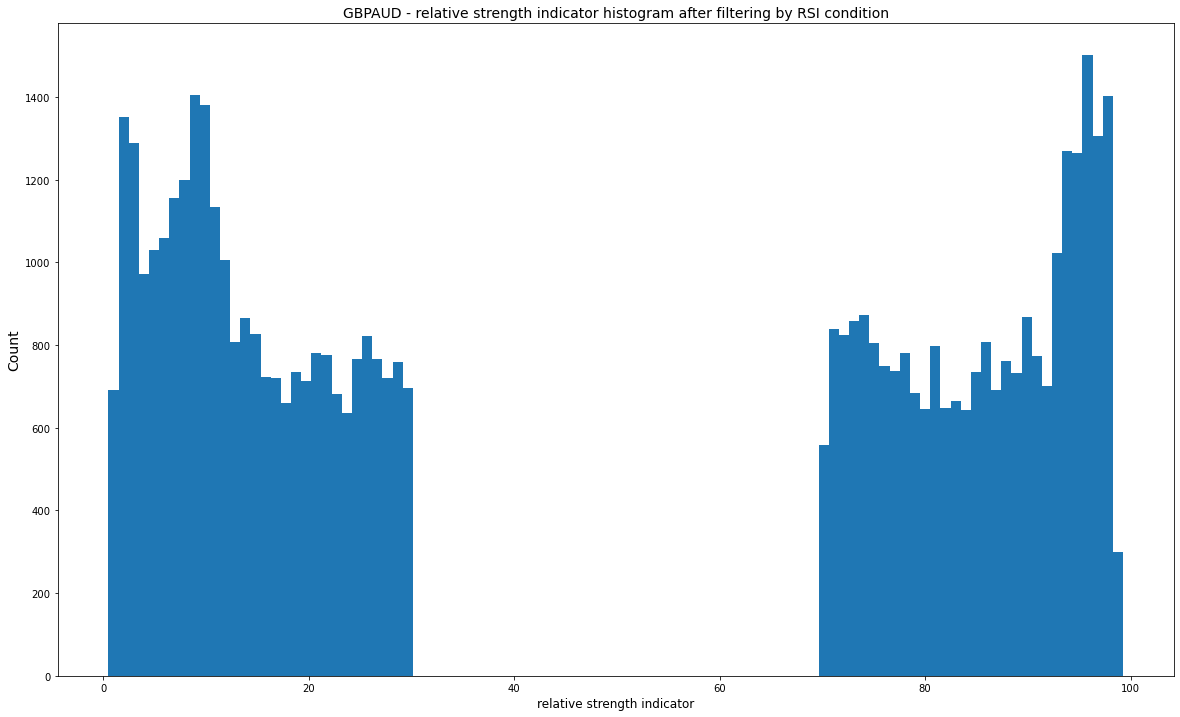

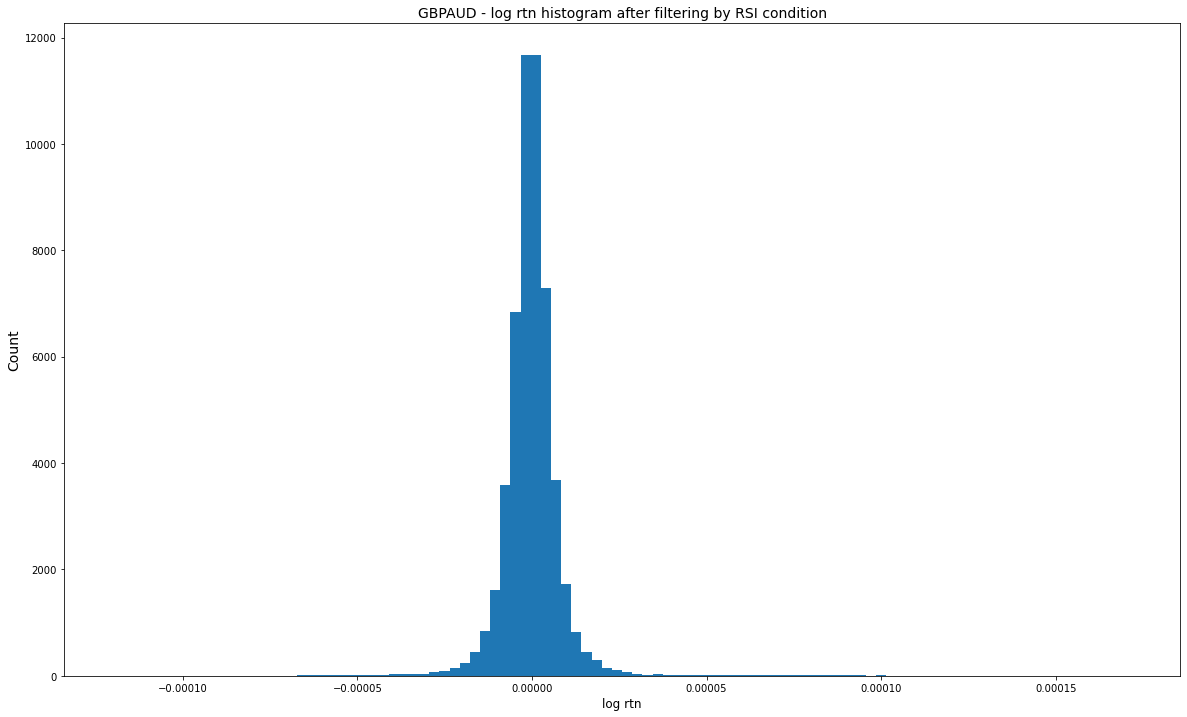

In [26]:
def plot_histograms_of_metrics_after_filtering_by_rsi_condition(data, metric, plot_outliers=False):
    fig, ax = plt.subplots(figsize=(20, 12))
    plot = data[data['RSI_condition']==1][metric].plot.hist(bins=100, ax=ax)
    
    plt.xlabel(metric.lower().replace('_', ' '), fontsize=12)
    plt.ylabel("Count", fontsize=14)
    
    # Plot outliers in color red, where an outlier is any data point outside 95% confidence interval (assuming normal distribution)
    if plot_outliers:
        mean = data[data['RSI_condition']==1][metric].mean()
        std_dev = data[data['RSI_condition']==1][metric].std()
        _lower = mean - 1.96 * std_dev
        _upper = mean + 1.96 * std_dev
        for rect in plot.patches:
            if rect.get_x() < _lower or rect.get_x() > _upper:
                rect.set_color('red')
        plt.title(f'''GBPAUD - {metric.lower().replace('_', ' ')} histogram after filtering by RSI condition with outliers in red''', fontsize=14)
    else:
        plt.title(f'''GBPAUD - {metric.lower().replace('_', ' ')} histogram after filtering by RSI condition''', fontsize=14)

    plt.show()


for metric in METRIC_COLUMNS:
    plot_histograms_of_metrics_after_filtering_by_rsi_condition(gbpaud_metrics_rsi_cond, metric)

## Next steps

This notebook has explored the raw tick and metrics data for your data understanding. Next, go through the example_tfx_training_pipeline.ipynb for an example of how to train an LSTM autoencoder to detect anomalies in the metrics data.